# Project Objective: 
Our group project aims to source movie data from various platforms
streamline and consolidate this information, and then identify correlations concerning rating, 
time, genres, production countries and gross revenue involvement.
We will then present our findings using compelling visualizations.

Source list for our data:
omdb API,
TMDB API,
Top 250 movies CSV file from kaggle,
golden_globe_awards.csv,
The Movies Dataset CSV file from Kaggle,
Oscars dataset CSV file,
Consumer Price Index GitHub Libary.

### Analyses presented in this file are particular to a random sample set of 1000. 

In [174]:
# Dependencies
import matplotlib.pyplot as plt
import requests
import pandas as pd
from scipy.stats import linregress
from config import tmdb_api_key
from config import omdb_api_key
import json
import numpy as np
import cpi
import time

# Importing data set from CSV 

In [177]:
# Check that the CSV was read properly
movie_import = pd.read_csv("Resources/movies_metadata.csv", low_memory=False)
print(movie_import.shape)
# movie_import.head()

(45466, 24)


## Data Cleaning

In [281]:
# Check the dataset's budget and revenue values to see how many entries don't have said data
print("Budget value counts:")
print(movie_import["budget"].value_counts())
print("---------------------------------------")
print("Revenue value counts:")
print(movie_import["revenue"].value_counts())

Budget value counts:
budget
0           36573
5000000       286
10000000      259
20000000      243
2000000       242
            ...  
923             1
72500000        1
2160000         1
4439832         1
1254040         1
Name: count, Length: 1226, dtype: int64
---------------------------------------
Revenue value counts:
revenue
0.0           38052
12000000.0       20
11000000.0       19
10000000.0       19
2000000.0        18
              ...  
36565280.0        1
439564.0          1
35610100.0        1
10217873.0        1
1413000.0         1
Name: count, Length: 6863, dtype: int64


In [282]:
# Drop duplicate movies (movie entries with the same title and release date) from the imported data
movie_import.drop_duplicates(subset=["release_date", "title"], keep='first', inplace=True)

In [283]:
# View if a movie had 0 budget or not (true/false)
# First, convert the budget column from a string to numeric and write NaN values to non-numeric cells
movie_import["budget"] = pd.to_numeric(movie_import['budget'], errors='coerce', downcast='integer')
no_budget = movie_import["budget"]==0
no_budget

0        False
1        False
2         True
3        False
4         True
         ...  
45461     True
45462     True
45463     True
45464     True
45465     True
Name: budget, Length: 45434, dtype: bool

In [367]:
# Create a DataFrame from the last cell's result
no_budget_df = movie_import[no_budget]
# Remove the rows with zero budget movies
movie_import=movie_import[~no_budget]
# movie_import

In [285]:
# View if a movie had 0 budget or not (true/false)
# First, convert the budget column from a string to numeric and write NaN values to non-numeric cells
movie_import["revenue"] = pd.to_numeric(movie_import["revenue"], errors="coerce", downcast="float")
no_revenue = movie_import["revenue"]==0
no_revenue

0        False
1        False
3        False
5        False
6         True
         ...  
45402     True
45408     True
45409    False
45412    False
45422    False
Name: revenue, Length: 8883, dtype: bool

In [368]:
# Create a DataFrame from the last block's result
no_revenue_df = movie_import[no_revenue]
# Remove the rows with zero budget movies
movie_import=movie_import[~no_revenue]
print(movie_import.shape)
# movie_import

In [287]:
# Check if there are any 0 values remaining for either budget or revenue
print(f"Budget check: ")
print(movie_import["budget"].min())
print(f"Revenue check: ")
print(movie_import["revenue"].min())

Budget check: 
1.0
Revenue check: 
1.0


In [369]:
# Further filter down the original movie dataset by removing movies with budgets and revenues less than $1000
movie_prep1 = movie_import[movie_import["budget"]>=1000]
movie_prep1 = movie_import[movie_import["revenue"]>=1000]
# movie_prep1

In [289]:
# Make a new DataFrame and import the title column from the metadata and make a blank id column to be populate
movie_prep2 = pd.DataFrame(movie_prep1["original_title"])
movie_prep2.rename(columns={"original_title": "Title"}, inplace=True)
movie_prep2['id'] = ''
movie_prep2

,Title,id
0,Toy Story,
1,Jumanji,
3,Waiting to Exhale,
5,Heat,
8,Sudden Death,
...,...,...
45167,Wind River,
45250,சிவாஜி,
45409,Dikari,
45412,Про любоff,


In [290]:
# Pull a random sample of 1000 movies from the cleaned dataset to be used for analysis
movie_list = movie_prep2.sample(1000)
movie_list = movie_list.reset_index(drop=True)
movie_list

,Title,id
0,劇場版ポケットモンスター ミュウツーの逆襲,
1,Bizim Aile,
2,Star Trek: The Motion Picture,
3,Money for Nothing,
4,Happy Feet,
...,...,...
995,Consenting Adults,
996,Mortdecai,
997,It Follows,
998,Duplex,


# API calling: 
### Test calling TMDB API and OMDB API

In [291]:
# Test a TMDB API call based on an index of the movie list and printing the json response
movie=movie_list['Title'][100]
base_url="https://api.themoviedb.org/3/search/movie?"
build_url = f'https://api.themoviedb.org/3/search/movie?query={movie}&api_key={tmdb_api_key}'
response=requests.get(build_url).json()
#print(response.url)
print(json.dumps(response, indent=4, sort_keys=True))

{
    "page": 1,
    "results": [
        {
            "adult": false,
            "backdrop_path": "/1ZyZvbZlvA6fFLWEPmbJ84G3kG1.jpg",
            "genre_ids": [
                35,
                80
            ],
            "id": 9809,
            "original_language": "en",
            "original_title": "Let's Go to Prison",
            "overview": "When a career criminal's plan for revenge is thwarted by unlikely circumstances, he puts his intended victim's son in his place by putting him in prison...and then joining him.",
            "popularity": 12.404,
            "poster_path": "/qjol2ENVwkR6UTIrOtf2gkol3AE.jpg",
            "release_date": "2006-11-17",
            "title": "Let's Go to Prison",
            "video": false,
            "vote_average": 5.703,
            "vote_count": 274
        },
        {
            "adult": false,
            "backdrop_path": "/cRlC47BVF8PjfpXlNdcuW3zefu4.jpg",
            "genre_ids": [
                35
            ],
            "

In [292]:
# Test an OMDB API call based on an index of the movie list and printing the json response
url = "http://www.omdbapi.com/?t="
api_key_url = "&apikey=" + omdb_api_key
movie_name=movie_list["Title"][250]
response = requests.get(url + movie_name + api_key_url).json()
print(json.dumps(response, indent=4, sort_keys=True))

{
    "Actors": "Denzel Washington, Whitney Houston, Courtney B. Vance",
    "Awards": "Nominated for 1 Oscar. 4 wins & 7 nominations total",
    "BoxOffice": "$48,102,795",
    "Country": "United States",
    "DVD": "03 Sep 2014",
    "Director": "Penny Marshall",
    "Genre": "Comedy, Drama, Fantasy",
    "Language": "English",
    "Metascore": "N/A",
    "Plot": "An angel comes to Earth to help a preacher save his church and his family.",
    "Poster": "https://m.media-amazon.com/images/M/MV5BOWFiMGMzYmYtMGZjNy00ZWVkLTllMjAtMTQ2NmU1OWVhMjkxXkEyXkFqcGdeQXVyNjU0NTI0Nw@@._V1_SX300.jpg",
    "Production": "N/A",
    "Rated": "PG",
    "Ratings": [
        {
            "Source": "Internet Movie Database",
            "Value": "5.7/10"
        },
        {
            "Source": "Rotten Tomatoes",
            "Value": "62%"
        }
    ],
    "Released": "13 Dec 1996",
    "Response": "True",
    "Runtime": "123 min",
    "Title": "The Preacher's Wife",
    "Type": "movie",
    "Website

### Data Preparation

In [293]:
# Loop through the CSV's Title column to call said movie from the TMDB API
# Create an empty list to store unfound movies in the TMDB database into
unfound_movies = []
for index, row in movie_list.iterrows():
    movie=movie_list['Title'][index]
    base_url="https://api.themoviedb.org/3/search/movie?"
    build_url = f'{base_url}query={movie}&api_key={tmdb_api_key}'
    response=requests.get(build_url).json()
    #print(response.url)

    try:
        movie_list.loc[index, "id"] = response['results'][0]['id']
    except (KeyError, IndexError):
        # If no movie name is found, set the movie id as NaN .
        movie_list.loc[index, "id"] = np.nan
        unfound_movies.append(movie_list.loc[index, "Title"])

# View the movies not found in the database
unfound_movies

['디워']

In [294]:
# Cleaning: drop any NaN rows
movie_list.dropna(how='any',inplace=True)
# Reset the index to not run into any index errors while looping later in the cleaning
movie_list.reset_index(drop=True)
# Re-check size of Data Frame
movie_list.shape

(999, 2)

In [295]:
# Add new columns to the DataFrame to be populated with the next TMDB API calls
movie_list[['imdb_id',
            'budget',
            'genres',
            'revenue',
            'runtime',
            'popularity',
            'release_date',
            'production_countries'
            ,'tmdb_rating']] =''
movie_list

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating
0,劇場版ポケットモンスター ミュウツーの逆襲,10228,,,,,,,,,
1,Bizim Aile,220002,,,,,,,,,
2,Star Trek: The Motion Picture,152,,,,,,,,,
3,Money for Nothing,55448,,,,,,,,,
4,Happy Feet,9836,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
995,Consenting Adults,37753,,,,,,,,,
996,Mortdecai,210860,,,,,,,,,
997,It Follows,270303,,,,,,,,,
998,Duplex,7288,,,,,,,,,


In [296]:
# Loop through each movie's title for the TMDB API call and store the data we want to analyze into our DataFrame

for index, row in movie_list.iterrows():
# Create empty lists to store multiple-value columns' data into 
    genres = []
    production_countries = []
    try:
        movie_id=movie_list['id'][index]
        base_url_ById = "https://api.themoviedb.org/3/movie/"
        build_url_ById=f"{base_url_ById}{movie_id}?api_key={tmdb_api_key}"
        url_byid_response=requests.get(build_url_ById).json()
        movie_list.loc[index, "imdb_id"] = url_byid_response['imdb_id']
        movie_list.loc[index, "release_date"] = url_byid_response['release_date']
        movie_list.loc[index, "revenue"] = url_byid_response['revenue']
        movie_list.loc[index, "runtime"]= url_byid_response['runtime']
        movie_list.loc[index, "Title"]= url_byid_response['title']

        
        
        # extract multiple genre names from the list
        for i in range(0,len(url_byid_response['genres'])):
            current_genre = url_byid_response['genres'][i]['name']
            genres.append(current_genre)
            

        # extract multiple production_countries names from the list
        for i in range(0,len(url_byid_response['production_countries'])):
            current_prod_country = url_byid_response['production_countries'][i]['name']
            production_countries.append(current_prod_country)

        movie_list.loc[index, "popularity"] = url_byid_response['popularity']
        movie_list.loc[index, "budget"] = url_byid_response['budget']
        movie_list.loc[index, "tmdb_rating"] = url_byid_response['vote_average']
        movie_list.loc[index, "genres"] = ", ".join(genres)
        movie_list.loc[index, "production_countries"] = ", ".join(production_countries)
    except (KeyError, IndexError):
        # If no movie name is found, set the movie id as NaN
        movie_list.loc[index, "imdb_id"] = np.nan
        movie_list.loc[index, "release_date"] = np.nan
        movie_list.loc[index, "revenue"] = np.nan
        movie_list.loc[index, "runtime"]= np.nan
        movie_list.loc[index, "popularity"] = np.nan
        movie_list.loc[index, "budget"] = np.nan
        movie_list.loc[index, "tmdb_rating"] = np.nan
        movie_list.loc[index, "production_countries"] = np.nan
        movie_list.loc[index, "genres"] = np.nan

        

In [297]:
# Make calls to the OMDB API to populate new rows with imdb ratings and their vote counts

for index, row in movie_list.iterrows():
    try:
        imdb_id=movie_list["imdb_id"][index]
        base_url_ById = "http://www.omdbapi.com/?i="
        build_url_ById=f"{base_url_ById}{imdb_id}&apikey={omdb_api_key}"
        url_byid_response=requests.get(build_url_ById).json()
        rating_url = url_byid_response['imdbRating']
        movie_list.loc[index, "imdb_rating"] = rating_url
        votes_url = url_byid_response['imdbVotes']
        movie_list.loc[index, "imdb_votes"] = votes_url
    except:
        movie_list.loc[index, "imdb_rating"] = np.nan
        movie_list.loc[index, "imdb_votes"] = np.nan
movie_list

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating,imdb_rating,imdb_votes
0,Pokémon: The First Movie,10228,tt0190641,30000000,"Animation, Family, Adventure, Fantasy, Action",163644662,85,25.593,1998-07-18,Japan,6.911,6.2,"44,979"
1,Our Family,220002,tt0456047,65700,"Comedy, Family, Drama",214600,88,4.175,1975-09-07,Turkey,7.779,8.4,"7,043"
2,Star Trek: The Motion Picture,152,tt0079945,35000000,"Science Fiction, Adventure, Mystery",139000000,132,27.74,1979-12-07,United States of America,6.489,6.4,"94,649"
3,Money for Nothing,55448,tt0107594,11000000,"Drama, Comedy, Crime",1044824,100,5.497,1993-09-10,United States of America,5.455,5.7,"4,245"
4,Happy Feet,9836,tt0366548,100000000,"Animation, Comedy, Family",384335608,108,41.868,2006-11-16,Australia,6.2,6.4,"195,145"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Consenting Adults,37753,tt0104006,18000000,"Thriller, Drama",21591728,99,12.05,1992-10-16,United States of America,5.3,5.7,"8,182"
996,Mortdecai,210860,tt3045616,60000000,"Comedy, Adventure",47318560,107,20.706,2015-01-21,United States of America,5.51,5.5,"75,737"
997,It Follows,270303,tt3235888,2000000,"Horror, Mystery",14674076,101,55.107,2014-09-24,United States of America,6.561,6.8,"259,070"
998,Duplex,7288,tt0266489,40000000,Comedy,19322135,89,16.607,2003-09-26,"Germany, United States of America",6.088,5.9,"59,817"


In [298]:
# Cleaning: drop any NaN rows
movie_list.dropna(how='any', inplace=True)
print(movie_list.shape)
movie_list = movie_list.reset_index(drop=True)

(994, 13)


In [299]:
import math
# Convert the release_date column to a proper format to pull only the year from and store to a new column
# Create a new "Year" column from the "release date" 
movie_list["release_date"] = pd.to_datetime(movie_list["release_date"])
movie_list["Year"] = movie_list["release_date"].dt.year

for i in range(0,len(movie_list["Year"])):
    value = movie_list.loc[i, "Year"]
    if math.isfinite(value):
        movie_list.loc[i, "Year"] = int(value)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "Year"] = np.nan
        #print(movie_list.loc[i, "Year"])
movie_list["Year"].dropna(how='any')
movie_list = movie_list.reset_index(drop=True)

In [300]:
# Display the DataFrame
movie_list

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating,imdb_rating,imdb_votes,Year
0,Pokémon: The First Movie,10228,tt0190641,30000000,"Animation, Family, Adventure, Fantasy, Action",163644662,85,25.593,1998-07-18,Japan,6.911,6.2,"44,979",1998
1,Our Family,220002,tt0456047,65700,"Comedy, Family, Drama",214600,88,4.175,1975-09-07,Turkey,7.779,8.4,"7,043",1975
2,Star Trek: The Motion Picture,152,tt0079945,35000000,"Science Fiction, Adventure, Mystery",139000000,132,27.74,1979-12-07,United States of America,6.489,6.4,"94,649",1979
3,Money for Nothing,55448,tt0107594,11000000,"Drama, Comedy, Crime",1044824,100,5.497,1993-09-10,United States of America,5.455,5.7,"4,245",1993
4,Happy Feet,9836,tt0366548,100000000,"Animation, Comedy, Family",384335608,108,41.868,2006-11-16,Australia,6.2,6.4,"195,145",2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,Consenting Adults,37753,tt0104006,18000000,"Thriller, Drama",21591728,99,12.05,1992-10-16,United States of America,5.3,5.7,"8,182",1992
990,Mortdecai,210860,tt3045616,60000000,"Comedy, Adventure",47318560,107,20.706,2015-01-21,United States of America,5.51,5.5,"75,737",2015
991,It Follows,270303,tt3235888,2000000,"Horror, Mystery",14674076,101,55.107,2014-09-24,United States of America,6.561,6.8,"259,070",2014
992,Duplex,7288,tt0266489,40000000,Comedy,19322135,89,16.607,2003-09-26,"Germany, United States of America",6.088,5.9,"59,817",2003


In [301]:
# Convert relevant columns to required data type
movie_list["tmdb_rating"] = pd.to_numeric(movie_list["tmdb_rating"], errors='coerce')
movie_list["imdb_rating"] = pd.to_numeric(movie_list["imdb_rating"], errors='coerce')

In [302]:
# Do more cleaning of the data by looping through numeric columns and replacing any non-numeric values with NaN

for i in range(0,len(movie_list["Year"])):
    value1 = movie_list.loc[i, "runtime"]
    if math.isfinite(value1):
        movie_list.loc[i, "runtime"] = int(value1)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "runtime"] = np.nan
    
    value2 = movie_list.loc[i, "budget"]
    if math.isfinite(value2):
        movie_list.loc[i, "budget"] = int(value2)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "budget"] = np.nan
    
    value3 = movie_list.loc[i, "revenue"]
    if math.isfinite(value3):
        movie_list.loc[i, "revenue"] = float(value3)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "revenue"] = np.nan
    
    value4 = movie_list.loc[i, "tmdb_rating"]
    if math.isfinite(value4):
        movie_list.loc[i, "tmdb_rating"] = float(value4)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "tmdb_rating"] = np.nan
    
    value5 = movie_list.loc[i, "imdb_rating"]
    if math.isfinite(value5):
        movie_list.loc[i, "imdb_rating"] = float(value5)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "imdb_rating"] = np.nan

NaN value found at index: 331
NaN value found at index: 502


In [303]:
# Drop the actual NaN values added in from the DataFrame
movie_list.dropna(how='any',inplace=True)
# Reset the index to not run into any index errors while looping later in the cleaning
movie_list.reset_index(drop=True)


,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating,imdb_rating,imdb_votes,Year
0,Pokémon: The First Movie,10228,tt0190641,30000000,"Animation, Family, Adventure, Fantasy, Action",163644662.0,85,25.593,1998-07-18,Japan,6.911,6.2,"44,979",1998
1,Our Family,220002,tt0456047,65700,"Comedy, Family, Drama",214600.0,88,4.175,1975-09-07,Turkey,7.779,8.4,"7,043",1975
2,Star Trek: The Motion Picture,152,tt0079945,35000000,"Science Fiction, Adventure, Mystery",139000000.0,132,27.74,1979-12-07,United States of America,6.489,6.4,"94,649",1979
3,Money for Nothing,55448,tt0107594,11000000,"Drama, Comedy, Crime",1044824.0,100,5.497,1993-09-10,United States of America,5.455,5.7,"4,245",1993
4,Happy Feet,9836,tt0366548,100000000,"Animation, Comedy, Family",384335608.0,108,41.868,2006-11-16,Australia,6.200,6.4,"195,145",2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,Consenting Adults,37753,tt0104006,18000000,"Thriller, Drama",21591728.0,99,12.05,1992-10-16,United States of America,5.300,5.7,"8,182",1992
988,Mortdecai,210860,tt3045616,60000000,"Comedy, Adventure",47318560.0,107,20.706,2015-01-21,United States of America,5.510,5.5,"75,737",2015
989,It Follows,270303,tt3235888,2000000,"Horror, Mystery",14674076.0,101,55.107,2014-09-24,United States of America,6.561,6.8,"259,070",2014
990,Duplex,7288,tt0266489,40000000,Comedy,19322135.0,89,16.607,2003-09-26,"Germany, United States of America",6.088,5.9,"59,817",2003


In [304]:
# Drop the old release date column and reorder the current DataFrame to be nicer
movie_list=movie_list[["Title",
                       "Year",
                       "id",
                       "imdb_id",
                       "genres",
                       "runtime",
                       "budget",
                       "revenue",
                       "production_countries",
                        "popularity",
                       "tmdb_rating",
                       "imdb_rating",
                       "imdb_votes"]]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes
0,Pokémon: The First Movie,1998,10228,tt0190641,"Animation, Family, Adventure, Fantasy, Action",85,30000000,163644662.0,Japan,25.593,6.911,6.2,"44,979"
1,Our Family,1975,220002,tt0456047,"Comedy, Family, Drama",88,65700,214600.0,Turkey,4.175,7.779,8.4,"7,043"
2,Star Trek: The Motion Picture,1979,152,tt0079945,"Science Fiction, Adventure, Mystery",132,35000000,139000000.0,United States of America,27.74,6.489,6.4,"94,649"
3,Money for Nothing,1993,55448,tt0107594,"Drama, Comedy, Crime",100,11000000,1044824.0,United States of America,5.497,5.455,5.7,"4,245"
4,Happy Feet,2006,9836,tt0366548,"Animation, Comedy, Family",108,100000000,384335608.0,Australia,41.868,6.200,6.4,"195,145"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,Consenting Adults,1992,37753,tt0104006,"Thriller, Drama",99,18000000,21591728.0,United States of America,12.05,5.300,5.7,"8,182"
990,Mortdecai,2015,210860,tt3045616,"Comedy, Adventure",107,60000000,47318560.0,United States of America,20.706,5.510,5.5,"75,737"
991,It Follows,2014,270303,tt3235888,"Horror, Mystery",101,2000000,14674076.0,United States of America,55.107,6.561,6.8,"259,070"
992,Duplex,2003,7288,tt0266489,Comedy,89,40000000,19322135.0,"Germany, United States of America",16.607,6.088,5.9,"59,817"


In [305]:
# Check the DataFrame's budget and revenue values to see how many entries don't have said data
print("Budget value counts:")
print(movie_list["budget"].value_counts())
print("---------------------------------------")
print("Revenue value counts:")
print(movie_list["revenue"].value_counts())

Budget value counts:
budget
25000000     42
30000000     38
0            38
10000000     32
15000000     29
             ..
650000        1
14200000      1
102000000     1
39000000      1
11178         1
Name: count, Length: 232, dtype: int64
---------------------------------------
Revenue value counts:
revenue
0.0            33
2000000.0       3
5000000.0       3
500000.0        3
150000000.0     3
               ..
1261000.0       1
792965500.0     1
84500122.0      1
235483004.0     1
108000000.0     1
Name: count, Length: 943, dtype: int64


In [306]:
# View if a movie had 0 budget or not (true/false)
no_budget = movie_list["budget"]==0
no_budget

0      False
1      False
2      False
3      False
4      False
       ...  
989    False
990    False
991    False
992    False
993    False
Name: budget, Length: 992, dtype: bool

In [307]:
# Create a DataFrame from the last block's result
no_budget_df = movie_list[no_budget]
# Remove rows with zero budget values
movie_list=movie_list[~no_budget]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes
0,Pokémon: The First Movie,1998,10228,tt0190641,"Animation, Family, Adventure, Fantasy, Action",85,30000000,163644662.0,Japan,25.593,6.911,6.2,"44,979"
1,Our Family,1975,220002,tt0456047,"Comedy, Family, Drama",88,65700,214600.0,Turkey,4.175,7.779,8.4,"7,043"
2,Star Trek: The Motion Picture,1979,152,tt0079945,"Science Fiction, Adventure, Mystery",132,35000000,139000000.0,United States of America,27.74,6.489,6.4,"94,649"
3,Money for Nothing,1993,55448,tt0107594,"Drama, Comedy, Crime",100,11000000,1044824.0,United States of America,5.497,5.455,5.7,"4,245"
4,Happy Feet,2006,9836,tt0366548,"Animation, Comedy, Family",108,100000000,384335608.0,Australia,41.868,6.200,6.4,"195,145"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,Consenting Adults,1992,37753,tt0104006,"Thriller, Drama",99,18000000,21591728.0,United States of America,12.05,5.300,5.7,"8,182"
990,Mortdecai,2015,210860,tt3045616,"Comedy, Adventure",107,60000000,47318560.0,United States of America,20.706,5.510,5.5,"75,737"
991,It Follows,2014,270303,tt3235888,"Horror, Mystery",101,2000000,14674076.0,United States of America,55.107,6.561,6.8,"259,070"
992,Duplex,2003,7288,tt0266489,Comedy,89,40000000,19322135.0,"Germany, United States of America",16.607,6.088,5.9,"59,817"


In [308]:
# View if a movie had 0 revenue or not (true/false)
no_revenue = movie_list["revenue"]==0
no_revenue

0      False
1      False
2      False
3      False
4      False
       ...  
989    False
990    False
991    False
992    False
993    False
Name: revenue, Length: 954, dtype: bool

In [309]:
# Remove rows of zero revenue movies
movie_list=movie_list[~no_revenue]
movie_list.reset_index(inplace=True, drop=True)
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes
0,Pokémon: The First Movie,1998,10228,tt0190641,"Animation, Family, Adventure, Fantasy, Action",85,30000000,163644662.0,Japan,25.593,6.911,6.2,"44,979"
1,Our Family,1975,220002,tt0456047,"Comedy, Family, Drama",88,65700,214600.0,Turkey,4.175,7.779,8.4,"7,043"
2,Star Trek: The Motion Picture,1979,152,tt0079945,"Science Fiction, Adventure, Mystery",132,35000000,139000000.0,United States of America,27.74,6.489,6.4,"94,649"
3,Money for Nothing,1993,55448,tt0107594,"Drama, Comedy, Crime",100,11000000,1044824.0,United States of America,5.497,5.455,5.7,"4,245"
4,Happy Feet,2006,9836,tt0366548,"Animation, Comedy, Family",108,100000000,384335608.0,Australia,41.868,6.200,6.4,"195,145"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,Consenting Adults,1992,37753,tt0104006,"Thriller, Drama",99,18000000,21591728.0,United States of America,12.05,5.300,5.7,"8,182"
947,Mortdecai,2015,210860,tt3045616,"Comedy, Adventure",107,60000000,47318560.0,United States of America,20.706,5.510,5.5,"75,737"
948,It Follows,2014,270303,tt3235888,"Horror, Mystery",101,2000000,14674076.0,United States of America,55.107,6.561,6.8,"259,070"
949,Duplex,2003,7288,tt0266489,Comedy,89,40000000,19322135.0,"Germany, United States of America",16.607,6.088,5.9,"59,817"


In [310]:
# Check if there are any 0 values remaining for either budget or revenue in the DataFrame
print(f"Budget check: ")
print(movie_list["budget"].min())
print(f"Revenue check: ")
print(movie_list["revenue"].min())

Budget check: 
6000
Revenue check: 
4775.0


In [311]:
# Create new columns in the DataFrame for inflation-adjusted budget and revenue
movie_list['infl_adj_budget'] = ''
movie_list['infl_adj_revenue'] = ''
movie_list

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_5196/455108519.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['infl_adj_budget'] = ''
/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_5196/455108519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['infl_adj_revenue'] = ''


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue
0,Pokémon: The First Movie,1998,10228,tt0190641,"Animation, Family, Adventure, Fantasy, Action",85,30000000,163644662.0,Japan,25.593,6.911,6.2,"44,979",,
1,Our Family,1975,220002,tt0456047,"Comedy, Family, Drama",88,65700,214600.0,Turkey,4.175,7.779,8.4,"7,043",,
2,Star Trek: The Motion Picture,1979,152,tt0079945,"Science Fiction, Adventure, Mystery",132,35000000,139000000.0,United States of America,27.74,6.489,6.4,"94,649",,
3,Money for Nothing,1993,55448,tt0107594,"Drama, Comedy, Crime",100,11000000,1044824.0,United States of America,5.497,5.455,5.7,"4,245",,
4,Happy Feet,2006,9836,tt0366548,"Animation, Comedy, Family",108,100000000,384335608.0,Australia,41.868,6.200,6.4,"195,145",,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,Consenting Adults,1992,37753,tt0104006,"Thriller, Drama",99,18000000,21591728.0,United States of America,12.05,5.300,5.7,"8,182",,
947,Mortdecai,2015,210860,tt3045616,"Comedy, Adventure",107,60000000,47318560.0,United States of America,20.706,5.510,5.5,"75,737",,
948,It Follows,2014,270303,tt3235888,"Horror, Mystery",101,2000000,14674076.0,United States of America,55.107,6.561,6.8,"259,070",,
949,Duplex,2003,7288,tt0266489,Comedy,89,40000000,19322135.0,"Germany, United States of America",16.607,6.088,5.9,"59,817",,


In [312]:
# The inflation calculator cannot calculate inflation for the current year, so find the films from 2023 to store
print("True = number of films from 2023")
find23 = movie_list["Year"]==2023
find23.value_counts()

True = number of films from 2023


Year
False    949
True       2
Name: count, dtype: int64

In [313]:
# Create a dataframe to hold onto the 2023 films to concatenate after inflation calculation
hold23 = movie_list[find23]
hold23

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue
189,Mission: Impossible - Dead Reckoning Part One,2023,575264,tt9603212,"Action, Thriller",164,291000000,567148955.0,United States of America,2032.927,7.721,7.9,"162,971",,
908,Teenage Mutant Ninja Turtles: Mutant Mayhem,2023,614930,tt8589698,"Animation, Comedy, Action",100,75000000,180000000.0,"Canada, France, United States of America",323.721,7.337,7.3,"42,049",,


In [314]:
# Populate the 2 new columns with current budget/revenue values since no inflation adjustment is needed
# Convert the data in the newly populated columns to the appropriate format to do math with later
hold23['infl_adj_budget'] = hold23['budget'].astype(int)
hold23['infl_adj_revenue'] = hold23['revenue'].astype(float)
hold23

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_5196/2159577572.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hold23['infl_adj_budget'] = hold23['budget'].astype(int)
/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_5196/2159577572.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hold23['infl_adj_revenue'] = hold23['revenue'].astype(float)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue
189,Mission: Impossible - Dead Reckoning Part One,2023,575264,tt9603212,"Action, Thriller",164,291000000,567148955.0,United States of America,2032.927,7.721,7.9,"162,971",291000000,567148955.0
908,Teenage Mutant Ninja Turtles: Mutant Mayhem,2023,614930,tt8589698,"Animation, Comedy, Action",100,75000000,180000000.0,"Canada, France, United States of America",323.721,7.337,7.3,"42,049",75000000,180000000.0


In [315]:
# Drop all rows with the year 2023 from the movie list
movie_list = movie_list[movie_list["Year"]<2023]
print(movie_list.shape)
movie_list.head()

(949, 15)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue
0,Pokémon: The First Movie,1998,10228,tt0190641,"Animation, Family, Adventure, Fantasy, Action",85,30000000,163644662.0,Japan,25.593,6.911,6.2,"44,979",,
1,Our Family,1975,220002,tt0456047,"Comedy, Family, Drama",88,65700,214600.0,Turkey,4.175,7.779,8.4,"7,043",,
2,Star Trek: The Motion Picture,1979,152,tt0079945,"Science Fiction, Adventure, Mystery",132,35000000,139000000.0,United States of America,27.74,6.489,6.4,"94,649",,
3,Money for Nothing,1993,55448,tt0107594,"Drama, Comedy, Crime",100,11000000,1044824.0,United States of America,5.497,5.455,5.7,"4,245",,
4,Happy Feet,2006,9836,tt0366548,"Animation, Comedy, Family",108,100000000,384335608.0,Australia,41.868,6.200,6.4,"195,145",,


### Adjusting each movie budget and revenue for inflation

In [316]:
# Define a function to calculate a running inflation adjusted value for a column in a dataframe
def inflate_column(data, column):
    #     Adjust for inflation the series of values in column of the dataframe data
    return data.apply(lambda x: cpi.inflate(x[column], x.Year), axis=1)

# adjust the production budget 
movie_list.loc[:,'budget'] = movie_list['budget'].astype(int)
movie_list.loc[:,'infl_adj_budget'] = inflate_column(movie_list, 'budget')
# adjust the worldwide gross profits
movie_list.loc[:,'infl_adj_revenue'] = inflate_column(movie_list, 'revenue').astype(float)

# calculate the real worldwide net profit
movie_list.loc[:,'real_profit'] = movie_list.apply(lambda x: x.infl_adj_revenue - x.infl_adj_budget, axis=1)
movie_list

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_5196/1440739579.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list.loc[:,'real_profit'] = movie_list.apply(lambda x: x.infl_adj_revenue - x.infl_adj_budget, axis=1)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit
0,Pokémon: The First Movie,1998,10228,tt0190641,"Animation, Family, Adventure, Fantasy, Action",85,30000000,163644662.0,Japan,25.593,6.911,6.2,"44,979",53862883.435583,293812445.138712,2.399496e+08
1,Our Family,1975,220002,tt0456047,"Comedy, Family, Drama",88,65700,214600.0,Turkey,4.175,7.779,8.4,"7,043",357387.239777,1167356.189591,8.099689e+05
2,Star Trek: The Motion Picture,1979,152,tt0079945,"Science Fiction, Adventure, Mystery",132,35000000,139000000.0,United States of America,27.74,6.489,6.4,"94,649",141087121.212121,560317424.242424,4.192303e+08
3,Money for Nothing,1993,55448,tt0107594,"Drama, Comedy, Crime",100,11000000,1044824.0,United States of America,5.497,5.455,5.7,"4,245",22278235.294118,2116075.901176,-2.016216e+07
4,Happy Feet,2006,9836,tt0366548,"Animation, Comedy, Family",108,100000000,384335608.0,Australia,41.868,6.200,6.4,"195,145",145166170.634921,557925284.52004,4.127591e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,Consenting Adults,1992,37753,tt0104006,"Thriller, Drama",99,18000000,21591728.0,United States of America,12.05,5.300,5.7,"8,182",37546614.397719,45038682.522024,7.492068e+06
947,Mortdecai,2015,210860,tt3045616,"Comedy, Adventure",107,60000000,47318560.0,United States of America,20.706,5.510,5.5,"75,737",74084559.335406,58426244.4331,-1.565831e+07
948,It Follows,2014,270303,tt3235888,"Horror, Mystery",101,2000000,14674076.0,United States of America,55.107,6.561,6.8,"259,070",2472416.531495,18140214.043407,1.566780e+07
949,Duplex,2003,7288,tt0266489,Comedy,89,40000000,19322135.0,"Germany, United States of America",16.607,6.088,5.9,"59,817",63620652.173913,30732170.75231,-3.288848e+07


In [317]:
# Concatenate DataFrames horizontally
movie_list = pd.concat([movie_list, hold23], axis=0)
movie_list.reset_index(inplace=True, drop=True)

In [318]:
# Look at a sampling of the dataframe
print(movie_list.shape)
movie_list.tail()

(951, 16)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit
946,It Follows,2014,270303,tt3235888,"Horror, Mystery",101,2000000,14674076.0,United States of America,55.107,6.561,6.8,"259,070",2472416.531495,18140214.043407,1.566780e+07
947,Duplex,2003,7288,tt0266489,Comedy,89,40000000,19322135.0,"Germany, United States of America",16.607,6.088,5.9,"59,817",63620652.173913,30732170.75231,-3.288848e+07
948,Three Kings,1999,6415,tt0120188,"Action, Comedy, War",114,75000000,108000000.0,United States of America,21.397,6.654,7.1,"177,766",131747448.979592,189716326.530612,5.796888e+07
949,Mission: Impossible - Dead Reckoning Part One,2023,575264,tt9603212,"Action, Thriller",164,291000000,567148955.0,United States of America,2032.927,7.721,7.9,"162,971",291000000,567148955.0,NaN
950,Teenage Mutant Ninja Turtles: Mutant Mayhem,2023,614930,tt8589698,"Animation, Comedy, Action",100,75000000,180000000.0,"Canada, France, United States of America",323.721,7.337,7.3,"42,049",75000000,180000000.0,NaN


In [319]:
# Do a final cleaning of the data by looping through numeric columns and replacing any non-numeric values with NaN
# Then, drop those NaN rows
for i in range(len(movie_list["Title"])):
    if movie_list.loc[i, "infl_adj_budget"]*0 != 0:
        movie_list.loc[i, "infl_adj_budget"] = np.nan
        print(f"NaN value found in the infl_adj_budget column at index: {i}")
        print(movie_list.loc[i, "infl_adj_budget"])
    if movie_list.loc[i, "infl_adj_revenue"]*0 != 0:
        movie_list.loc[i, "infl_adj_revenue"] = np.nan
        print(f"NaN value found in the infl_adj_revenue column at index: {i}")
        print(movie_list.loc[i, "infl_adj_revenue"])


movie_list.dropna(how='any',inplace=True)
# Reset the index to not run into any index errors while looping later in the cleaning
movie_list.reset_index(drop=True)

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit
0,Pokémon: The First Movie,1998,10228,tt0190641,"Animation, Family, Adventure, Fantasy, Action",85,30000000,163644662.0,Japan,25.593,6.911,6.2,"44,979",53862883.435583,293812445.138712,2.399496e+08
1,Our Family,1975,220002,tt0456047,"Comedy, Family, Drama",88,65700,214600.0,Turkey,4.175,7.779,8.4,"7,043",357387.239777,1167356.189591,8.099689e+05
2,Star Trek: The Motion Picture,1979,152,tt0079945,"Science Fiction, Adventure, Mystery",132,35000000,139000000.0,United States of America,27.74,6.489,6.4,"94,649",141087121.212121,560317424.242424,4.192303e+08
3,Money for Nothing,1993,55448,tt0107594,"Drama, Comedy, Crime",100,11000000,1044824.0,United States of America,5.497,5.455,5.7,"4,245",22278235.294118,2116075.901176,-2.016216e+07
4,Happy Feet,2006,9836,tt0366548,"Animation, Comedy, Family",108,100000000,384335608.0,Australia,41.868,6.200,6.4,"195,145",145166170.634921,557925284.52004,4.127591e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,Consenting Adults,1992,37753,tt0104006,"Thriller, Drama",99,18000000,21591728.0,United States of America,12.05,5.300,5.7,"8,182",37546614.397719,45038682.522024,7.492068e+06
945,Mortdecai,2015,210860,tt3045616,"Comedy, Adventure",107,60000000,47318560.0,United States of America,20.706,5.510,5.5,"75,737",74084559.335406,58426244.4331,-1.565831e+07
946,It Follows,2014,270303,tt3235888,"Horror, Mystery",101,2000000,14674076.0,United States of America,55.107,6.561,6.8,"259,070",2472416.531495,18140214.043407,1.566780e+07
947,Duplex,2003,7288,tt0266489,Comedy,89,40000000,19322135.0,"Germany, United States of America",16.607,6.088,5.9,"59,817",63620652.173913,30732170.75231,-3.288848e+07


# Movie Data Analysis

In [320]:
# Group the release years of the movies into Decades bins

# Define custom bin edges 
bin_edges = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
labels =["1920s", "1930s", "1940s", "1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010s", "2020s"]

# Cut the data into custom intervals
movie_list.loc[:,'Decades'] = pd.cut(movie_list['Year'], bins=bin_edges,labels=labels)
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades
0,Pokémon: The First Movie,1998,10228,tt0190641,"Animation, Family, Adventure, Fantasy, Action",85,30000000,163644662.0,Japan,25.593,6.911,6.2,"44,979",53862883.435583,293812445.138712,2.399496e+08,1990s
1,Our Family,1975,220002,tt0456047,"Comedy, Family, Drama",88,65700,214600.0,Turkey,4.175,7.779,8.4,"7,043",357387.239777,1167356.189591,8.099689e+05,1970s
2,Star Trek: The Motion Picture,1979,152,tt0079945,"Science Fiction, Adventure, Mystery",132,35000000,139000000.0,United States of America,27.74,6.489,6.4,"94,649",141087121.212121,560317424.242424,4.192303e+08,1970s
3,Money for Nothing,1993,55448,tt0107594,"Drama, Comedy, Crime",100,11000000,1044824.0,United States of America,5.497,5.455,5.7,"4,245",22278235.294118,2116075.901176,-2.016216e+07,1990s
4,Happy Feet,2006,9836,tt0366548,"Animation, Comedy, Family",108,100000000,384335608.0,Australia,41.868,6.200,6.4,"195,145",145166170.634921,557925284.52004,4.127591e+08,2000s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,Consenting Adults,1992,37753,tt0104006,"Thriller, Drama",99,18000000,21591728.0,United States of America,12.05,5.300,5.7,"8,182",37546614.397719,45038682.522024,7.492068e+06,1990s
945,Mortdecai,2015,210860,tt3045616,"Comedy, Adventure",107,60000000,47318560.0,United States of America,20.706,5.510,5.5,"75,737",74084559.335406,58426244.4331,-1.565831e+07,2010s
946,It Follows,2014,270303,tt3235888,"Horror, Mystery",101,2000000,14674076.0,United States of America,55.107,6.561,6.8,"259,070",2472416.531495,18140214.043407,1.566780e+07,2010s
947,Duplex,2003,7288,tt0266489,Comedy,89,40000000,19322135.0,"Germany, United States of America",16.607,6.088,5.9,"59,817",63620652.173913,30732170.75231,-3.288848e+07,2000s


In [321]:
# Sort the movie_list revenue column by descending values
sorted_revenue_desc = movie_list.sort_values(by='infl_adj_revenue', ascending=False)
top_ten_df = sorted_revenue_desc.iloc[0:10, :] 
top_ten_df

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades
626,Titanic,1997,597,tt0120338,"Drama, Romance",194,200000000,2264162353.0,United States of America,133.844,7.900,7.9,"1,248,724",364679127.725857,4128463759.608816,3.763785e+09,1990s
536,Snow White and the Seven Dwarfs,1937,408,tt0029583,"Fantasy, Animation, Family",83,1488423,184925486.0,United States of America,84.641,7.120,7.6,"210,202",30249613.407292,3758289451.759027,3.728040e+09,1930s
688,Cinderella,1950,11224,tt0042332,"Family, Fantasy, Animation, Romance",74,2900000,263600000.0,United States of America,98.219,7.000,7.3,"169,742",35215746.887967,3200989958.506224,3.165774e+09,1940s
325,E.T. the Extra-Terrestrial,1982,601,tt0083866,"Science Fiction, Adventure, Family, Fantasy",115,10500000,792965500.0,United States of America,38.549,7.512,7.9,"427,116",31843290.15544,2404821952.357512,2.372979e+09,1980s
750,The Empire Strikes Back,1980,1891,tt0080684,"Adventure, Action, Science Fiction",124,18000000,538400000.0,United States of America,28.096,8.391,8.7,"1,344,359",63929490.291262,1912202087.378641,1.848273e+09,1970s
187,The Jungle Book,1967,9325,tt0061852,"Family, Animation, Adventure",78,4000000,205843612.0,United States of America,56.885,7.277,7.6,"193,585",35048502.994012,1803627612.87006,1.768579e+09,1960s
574,The Lord of the Rings: The Return of the King,2003,122,tt0167260,"Adventure, Fantasy, Action",201,94000000,1118888979.0,"New Zealand, United States of America",98.322,8.475,9.0,"1,920,154",149508532.608696,1779611163.854592,1.630103e+09,2000s
471,Avengers: Age of Ultron,2015,99861,tt2395427,"Action, Adventure, Science Fiction",141,365000000,1405403694.0,United States of America,84.785,7.275,7.3,"900,297",450681069.290388,1735311889.305704,1.284631e+09,2010s
501,Frozen,2013,109445,tt2294629,"Animation, Family, Adventure, Fantasy",102,150000000,1274219009.0,United States of America,95.609,7.246,7.4,"648,268",188439282.786094,1600752774.455779,1.412313e+09,2010s
547,Independence Day,1996,602,tt0116629,"Action, Adventure, Science Fiction",145,75000000,817400891.0,United States of America,52.538,6.868,7.0,"594,628",139892447.418738,1524642815.523295,1.384750e+09,1990s


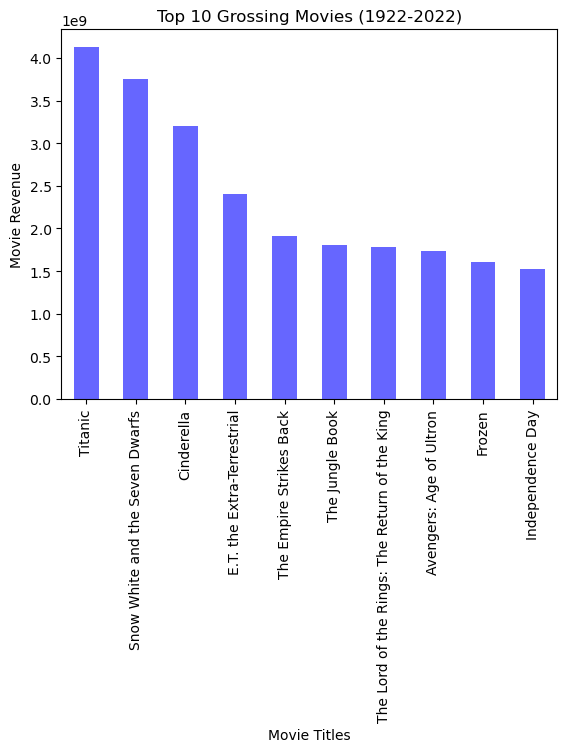

In [322]:
# Create a bar chart to display top 10 grossing movies
top_ten_df.plot("Title",
                "infl_adj_revenue",
                kind='bar',
                alpha=0.6,
                color='blue',
                title="Top 10 Grossing Movies (1922-2022)",
                xlabel="Movie Titles",
                ylabel="Movie Revenue",
                legend='')

# Export an image of this figure to the 'Output' folder
plt.savefig("Output/01 Top 10 Grossing Movies.png", bbox_inches='tight')

In [323]:
# Create a copy of the main DataFrame and make new 'country' columns to split the produciton_country data into
country_df = movie_list.copy(deep=True)
country_df[['country1', 'country2', 'country3', 'country4', 'country5', 'country6']] = country_df['production_countries'].str.split(', ', expand=True, n=5)
country_df.sample(10)

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,...,infl_adj_budget,infl_adj_revenue,real_profit,Decades,country1,country2,country3,country4,country5,country6
639,Wet Hot American Summer,2001,2171,tt0243655,Comedy,97,5000000,295206.0,United States of America,7.66,...,8262422.360248,487823.331056,-7.774599e+06,2000s,United States of America,None,None,None,None,None
286,Truth,2015,300693,tt3859076,Drama,125,9600000,5383097.0,"United States of America, Australia",11.934,...,11853529.493665,6646739.485079,-5.206790e+06,2010s,United States of America,Australia,None,None,None,None
181,Let's Be Cops,2014,193893,tt1924435,Comedy,104,17000000,136621271.0,United States of America,39.346,...,21015540.517707,168892344.487129,1.478768e+08,2010s,United States of America,None,None,None,None,None
345,Detroit Rock City,1999,9781,tt0165710,"Comedy, Music",95,6500000,4217115.0,United States of America,10.855,...,11418112.244898,7407921.910714,-4.010190e+06,1990s,United States of America,None,None,None,None,None
28,Café Society,2016,339397,tt4513674,"Comedy, Drama, Romance",97,30000000,43763247.0,United States of America,11.383,...,36580808.059765,53363164.619303,1.678236e+07,2010s,United States of America,None,None,None,None,None
319,Kill Bill: Vol. 2,2004,393,tt0378194,"Action, Crime, Thriller",136,30000000,152159461.0,United States of America,32.465,...,46477766.013764,235734394.171281,1.892566e+08,2000s,United States of America,None,None,None,None,None
909,Lost River,2015,167810,tt2366608,"Fantasy, Thriller, Drama",95,2000000,45431.0,United States of America,10.01,...,2469485.31118,56095.593586,-2.413390e+06,2010s,United States of America,None,None,None,None,None
280,Jackie,2016,376866,tt1619029,Drama,100,9000000,13960394.0,"Chile, France, United States of America",12.271,...,10974242.417929,17022749.778423,6.048507e+06,2010s,Chile,France,United States of America,None,None,None
420,Kubo and the Two Strings,2016,313297,tt4302938,"Animation, Adventure, Family",102,60000000,76249438.0,United States of America,34.969,...,73161616.11953,92975535.204765,1.981392e+07,2010s,United States of America,None,None,None,None,None
850,Percy Jackson: Sea of Monsters,2013,76285,tt1854564,"Adventure, Family, Fantasy",106,90000000,199850315.0,United States of America,29.928,...,113063569.671656,251064333.487833,1.380008e+08,2010s,United States of America,None,None,None,None,None


# Data Visualization

## Top Production Countries

In [324]:
# Sort the movies by highest grossers
country_df2 = country_df.sort_values(by='infl_adj_revenue', ascending=False)
country_df3 = country_df2.iloc[0:50, :]
country_df3

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,...,infl_adj_budget,infl_adj_revenue,real_profit,Decades,country1,country2,country3,country4,country5,country6
626,Titanic,1997,597,tt0120338,"Drama, Romance",194,200000000,2264162353.0,United States of America,133.844,...,364679127.725857,4128463759.608816,3.763785e+09,1990s,United States of America,None,None,None,None,None
536,Snow White and the Seven Dwarfs,1937,408,tt0029583,"Fantasy, Animation, Family",83,1488423,184925486.0,United States of America,84.641,...,30249613.407292,3758289451.759027,3.728040e+09,1930s,United States of America,None,None,None,None,None
688,Cinderella,1950,11224,tt0042332,"Family, Fantasy, Animation, Romance",74,2900000,263600000.0,United States of America,98.219,...,35215746.887967,3200989958.506224,3.165774e+09,1940s,United States of America,None,None,None,None,None
325,E.T. the Extra-Terrestrial,1982,601,tt0083866,"Science Fiction, Adventure, Family, Fantasy",115,10500000,792965500.0,United States of America,38.549,...,31843290.15544,2404821952.357512,2.372979e+09,1980s,United States of America,None,None,None,None,None
750,The Empire Strikes Back,1980,1891,tt0080684,"Adventure, Action, Science Fiction",124,18000000,538400000.0,United States of America,28.096,...,63929490.291262,1912202087.378641,1.848273e+09,1970s,United States of America,None,None,None,None,None
187,The Jungle Book,1967,9325,tt0061852,"Family, Animation, Adventure",78,4000000,205843612.0,United States of America,56.885,...,35048502.994012,1803627612.87006,1.768579e+09,1960s,United States of America,None,None,None,None,None
574,The Lord of the Rings: The Return of the King,2003,122,tt0167260,"Adventure, Fantasy, Action",201,94000000,1118888979.0,"New Zealand, United States of America",98.322,...,149508532.608696,1779611163.854592,1.630103e+09,2000s,New Zealand,United States of America,None,None,None,None
471,Avengers: Age of Ultron,2015,99861,tt2395427,"Action, Adventure, Science Fiction",141,365000000,1405403694.0,United States of America,84.785,...,450681069.290388,1735311889.305704,1.284631e+09,2010s,United States of America,None,None,None,None,None
501,Frozen,2013,109445,tt2294629,"Animation, Family, Adventure, Fantasy",102,150000000,1274219009.0,United States of America,95.609,...,188439282.786094,1600752774.455779,1.412313e+09,2010s,United States of America,None,None,None,None,None
547,Independence Day,1996,602,tt0116629,"Action, Adventure, Science Fiction",145,75000000,817400891.0,United States of America,52.538,...,139892447.418738,1524642815.523295,1.384750e+09,1990s,United States of America,None,None,None,None,None


In [325]:
# Identify a unique list of production countries for the Top 50 grossing movies
countries = list(country_df3["country1"].unique())
countries

['United States of America', 'New Zealand', 'United Kingdom', 'Czech Republic']

In [326]:
# Prepare the data to be visualized
# Import dependencies needed for world map visualizations
import matplotlib.pyplot as plt
import hvplot.pandas
import geoviews
import geopandas 

# Load the world map GeoDataFrame
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Filter the GeoDataFrame to select the list of top 10 grossing films' production countries
country_data = []
for i in range(len(countries)):
    country_data.append(world[world['name'] == countries[i]])

# Print the USA GeoDataFrame
print(country_data)

[     pop_est      continent                      name iso_a3  gdp_md_est  \
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  ,      pop_est continent         name iso_a3  gdp_md_est  \
136  4510327   Oceania  New Zealand    NZL    174800.0   

                                              geometry  
136  MULTIPOLYGON (((176.88582 -40.06598, 176.50802...  ,       pop_est continent            name iso_a3  gdp_md_est  \
143  64769452    Europe  United Kingdom    GBR   2788000.0   

                                              geometry  
143  MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...  , Empty GeoDataFrame
Columns: [pop_est, continent, name, iso_a3, gdp_md_est, geometry]
Index: []]


/Users/carterjackson/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/carterjackson/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/carterjackson/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/carterjackson/anaconda3/lib/python3.11/site-packages/geopandas/plo

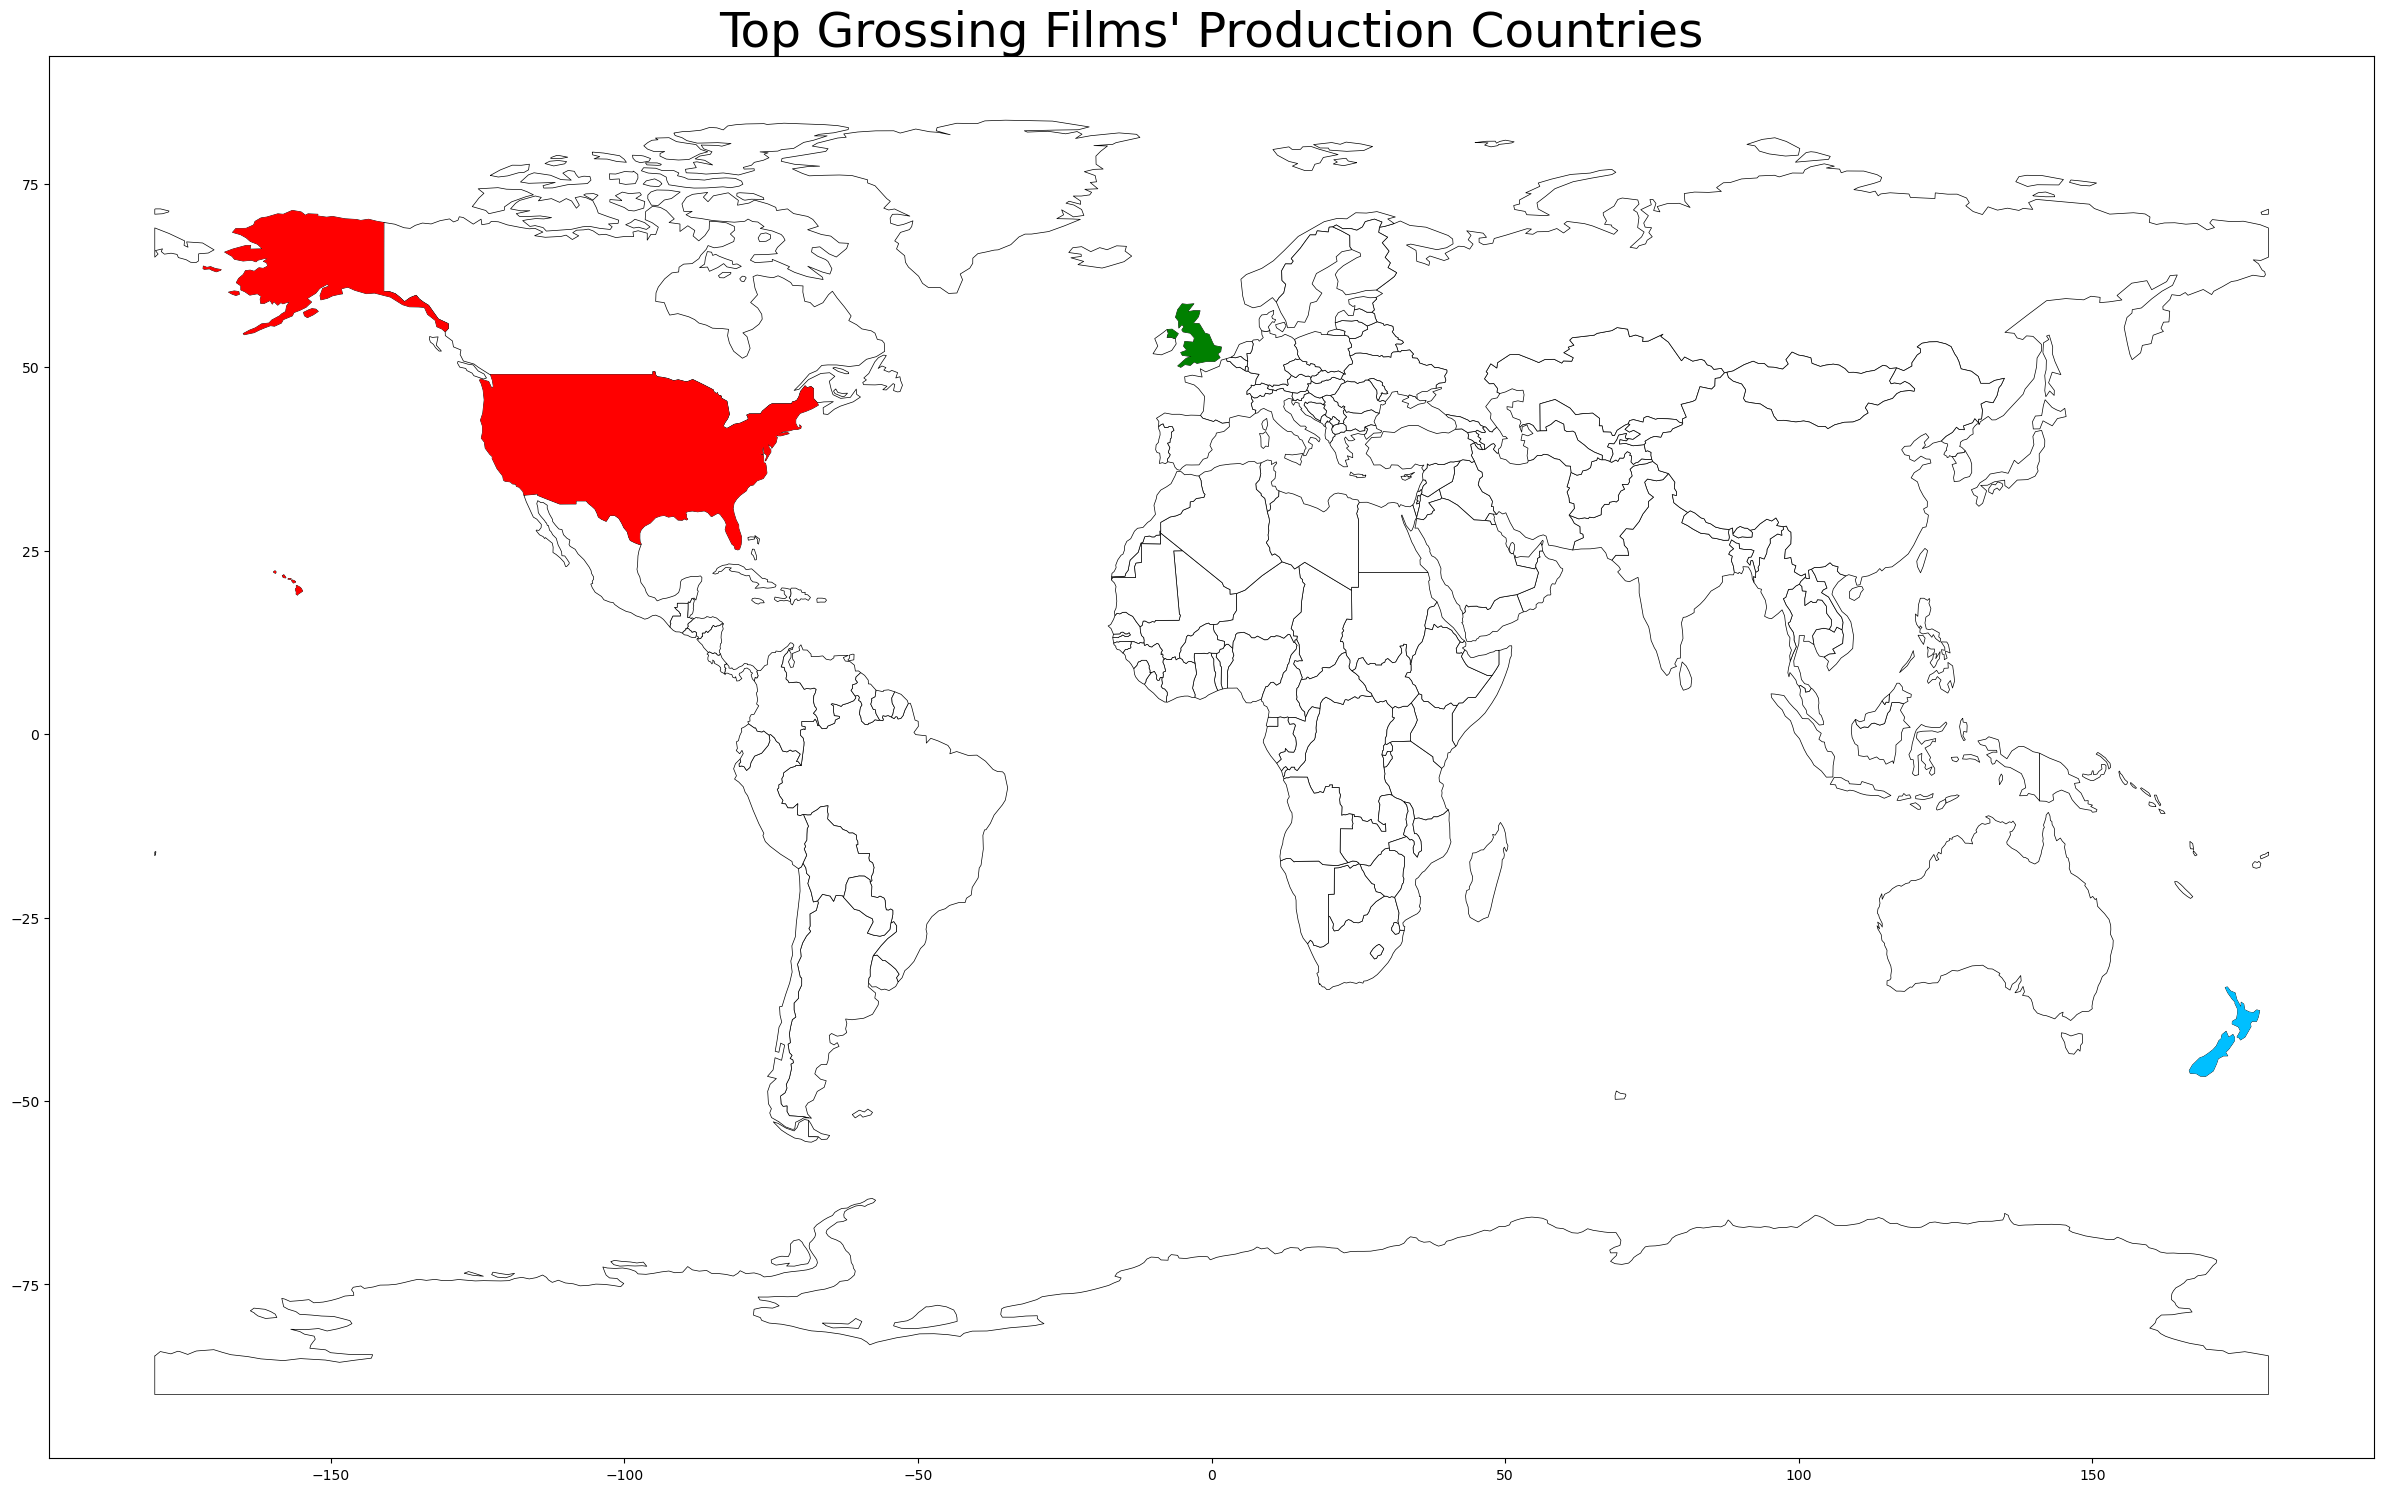

In [327]:
# Create visualization
# Create a base world map
world.plot(color='w', figsize=(30, 20), edgecolor='black', aspect="auto", linewidth=0.5)

# Create a list of colors to be looped through when plotting the list of countries
colors = ['red', 'deepskyblue', 'green', 'yellow', 'purple', 'orange', 'pink', 'cyan', 'peachpuff', 'gold', 
          'firebrick', 'darkturquoise', 'blueviolet', 'maroon']

for i in range(len(country_data)):
    current_color = colors[i % len(colors)] 
    country_data[i].plot(color=current_color, alpha=1, aspect='1.25', ax=plt.gca())

plt.title(f"Top Grossing Films' Production Countries", fontsize=35)

# Export an image of this figure to the 'Output' folder
plt.savefig("Output/02 Top Grossing Films Coutries.png", bbox_inches='tight')
plt.show()

### Production Country Analysis: 

Movies are most frequently produced in the countries listed above. All of them may not be represented in the map above. This observation is representative of the sample data set from the initial movie list.

## Distribution of Movies Produced per Decade

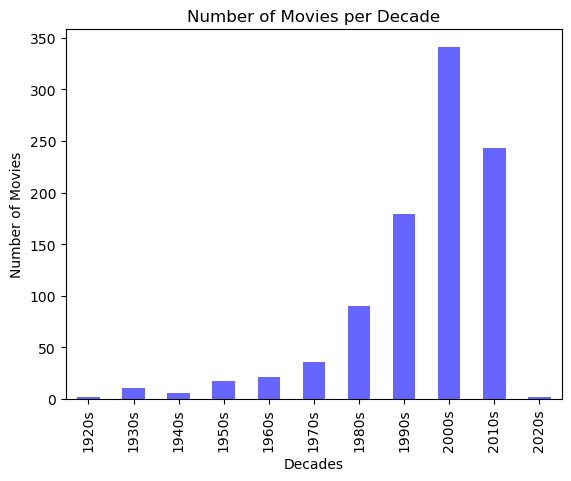

In [328]:
# Create a bar chart based upon the above data
y_axis=movie_list.groupby('Decades').count()['Title']
y_axis.plot(kind='bar',
            alpha=0.6,
            color='blue',
            title="Number of Movies per Decade",
            xlabel="Decades",
            ylabel="Number of Movies")

# Export an image of this figure to the 'Output' folder
plt.savefig("Output/03 Number of Movies per Decade.png", bbox_inches='tight')

### Movie Production Distribution Analysis:
Production of movies peaked in 2000s. It increased every year from 1920-2000.

## Number of Movies Produced based on varying budgets

In [329]:
# Categorizing budget into Low, Average, High

# Minimum Budget
min_budget = movie_list['infl_adj_budget'].min()
# Average Budget
avg_budget = movie_list['infl_adj_budget'].mean()
# Maximum Budget
max_budget = movie_list['infl_adj_budget'].max()

# Spliting the budget into three ranges 
diff = (max_budget-min_budget)/3

# Define the bins and labels
bins=[min_budget,round(min_budget+diff),round(min_budget+2*diff),round(min_budget+3*diff)]
labels = ['Low Budget', 'Average Budget', 'High Budget']
# Cut the 'Budget' column into categories and create a new column 'Budget_Category'
movie_list['Budget_Category'] = pd.cut(movie_list['infl_adj_budget'], bins=bins, labels=labels)
movie_list.sample(10)

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category
56,Flyboys,2006,9664,tt0454824,"Action, Adventure, Drama, History, Romance, War",138,60000000,17834865.0,"United Kingdom, United States of America",15.116,6.529,6.5,"43,841",87099702.380952,25890190.558408,-6.120951e+07,2000s,Low Budget
170,Friday Night Lights,2004,13416,tt0390022,Drama,118,30000000,61255921.0,United States of America,12.722,6.918,7.2,"65,884",46477766.013764,94901278.773187,4.842351e+07,2000s,Low Budget
574,The Lord of the Rings: The Return of the King,2003,122,tt0167260,"Adventure, Fantasy, Action",201,94000000,1118888979.0,"New Zealand, United States of America",98.322,8.475,9.0,"1,920,154",149508532.608696,1779611163.854592,1.630103e+09,2000s,Low Budget
672,Metropolis,1927,19,tt0017136,"Drama, Science Fiction",149,1300000,650422.0,Germany,19.553,8.200,8.3,"180,970",21865028.735632,10939612.092529,-1.092542e+07,1920s,Low Budget
335,Land of the Dead,2005,11683,tt0418819,"Horror, Science Fiction",93,15000000,47074133.0,"Canada, United States of America, France",19.351,6.189,6.2,"99,314",22477342.549923,70540094.178776,4.806275e+07,2000s,Low Budget
587,Shooter,2007,7485,tt0822854,"Action, Drama, Mystery, Thriller, Crime",124,61000000,95696996.0,United States of America,47.837,7.098,7.1,"348,097",86099077.852051,135072509.980515,4.897343e+07,2000s,Low Budget
161,Julia,1977,42222,tt0076245,Drama,117,7840000,20700000.0,United States of America,7.319,6.560,7.1,"10,226",37861636.963696,99966311.881188,6.210467e+07,1970s,Low Budget
171,Queen of Spades: The Dark Rite,2015,358962,tt4901756,Horror,94,1000000,2228115.0,Russia,5.923,5.323,5.3,"1,613",1234742.65559,2751148.63206,1.516406e+06,2010s,Low Budget
911,Malcolm X,1992,1883,tt0104797,"Drama, History",202,34000000,48169908.0,United States of America,18.048,7.543,7.7,"99,531",70921382.751247,100478720.069423,2.955734e+07,1990s,Low Budget
901,The Three Stooges,2012,76489,tt0383010,Comedy,92,30000000,54819301.0,United States of America,24.701,5.779,5.1,"32,708",38239893.028563,69876140.204687,3.163625e+07,2010s,Low Budget


  Budget_Category  count
0      Low Budget    891
1  Average Budget     51
2     High Budget      5


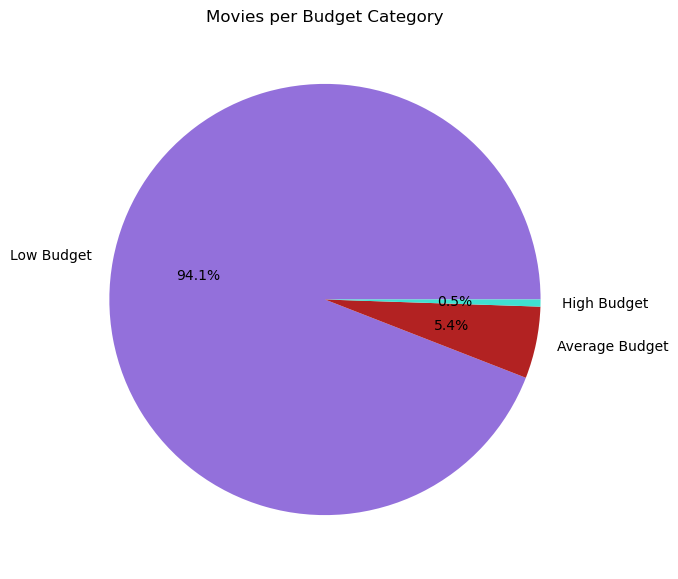

In [330]:
# Create visualization
# Pie plot showing the distribution of Budget category using pyplot
budget_distribution = movie_list['Budget_Category'].value_counts().reset_index()
print(budget_distribution)
#create y label
y = [budget_distribution['count'][0],budget_distribution['count'][1],budget_distribution['count'][2]]
#Show Pie Plot
plt.figure(figsize=(10,7))
plt.title("Movies per Budget Category")
plt.pie(y,autopct='%1.1f%%',
        labels=['Low Budget','Average Budget','High Budget'],
        colors=['mediumpurple', 'firebrick', 'turquoise'])

# Export an image of this figure to the 'Output' folder
plt.savefig("Output/04 Movies per Budget Category.png", bbox_inches='tight')
plt.show()

###  Analysis of Movies Produced per Budget Category
Over 80% movies observed in our sample set is made with a budget in the low budget category. 
Less that 10% movies observed in our sample set is made with a budget in the average budget category.
Less than 2% movies observed in our sample set is made with a budget in the high budget category.

## Movies per Budget Range by Decade

<Figure size 1000x200 with 0 Axes>

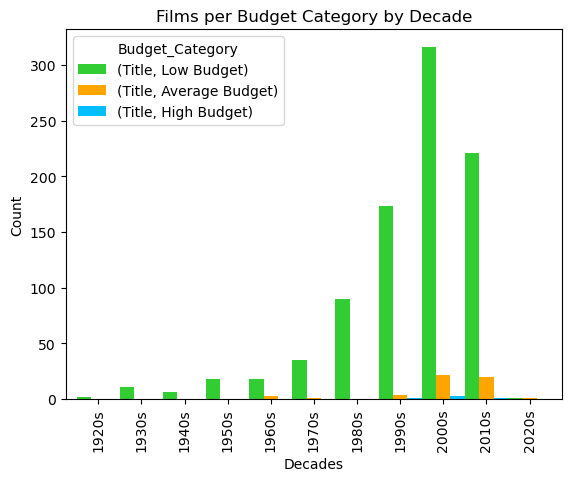

In [331]:
# Create Visualization
# Bar plot Budget Categories by Decades
grouped_df = movie_list.groupby(['Decades', 'Budget_Category'])['Title'].count().reset_index()
pivot_df=grouped_df.set_index(['Decades', 'Budget_Category'])
pivot_unstacked=pivot_df.unstack()
# Set the figure size
plt.figure(figsize=(10,2))  # Width, Height in inches
# Create a stacked bar plot
pivot_unstacked.plot(kind='bar',width=1,color=['limegreen', 'orange', 'deepskyblue'], stacked=False)
# Add labels and a title
plt.xlabel('Decades')
plt.ylabel('Count')
plt.title('Films per Budget Category by Decade')
plt.legend(title='Budget_Category')

# Export an image of this figure to the 'Output' folder
plt.savefig("Output/05 Films per Budget Category by Decade.png", bbox_inches='tight')
#Show the plot
plt.show()

### Analysis of Movies per Budget Range by Decade
Production of movies peaked in 2000s. It increased every year from 1920-2009.

##  Number of Movies Produced based on their Primary Genre

In [332]:
# Prepare the data frame to study the genre
genre_df = movie_list.copy(deep=True)
# genre_df
genre_df[['primary_genre',
          'sub_genre_1',
          'sub_genre_2',
          'sub_genre_3',
          'sub_genre_4',
          'sub_genre_5']] = genre_df['genres'].str.split(', ', expand=True, n=5)
genre_df

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,...,infl_adj_revenue,real_profit,Decades,Budget_Category,primary_genre,sub_genre_1,sub_genre_2,sub_genre_3,sub_genre_4,sub_genre_5
0,Pokémon: The First Movie,1998,10228,tt0190641,"Animation, Family, Adventure, Fantasy, Action",85,30000000,163644662.0,Japan,25.593,...,293812445.138712,2.399496e+08,1990s,Low Budget,Animation,Family,Adventure,Fantasy,Action,None
1,Our Family,1975,220002,tt0456047,"Comedy, Family, Drama",88,65700,214600.0,Turkey,4.175,...,1167356.189591,8.099689e+05,1970s,Low Budget,Comedy,Family,Drama,None,None,None
2,Star Trek: The Motion Picture,1979,152,tt0079945,"Science Fiction, Adventure, Mystery",132,35000000,139000000.0,United States of America,27.74,...,560317424.242424,4.192303e+08,1970s,Low Budget,Science Fiction,Adventure,Mystery,None,None,None
3,Money for Nothing,1993,55448,tt0107594,"Drama, Comedy, Crime",100,11000000,1044824.0,United States of America,5.497,...,2116075.901176,-2.016216e+07,1990s,Low Budget,Drama,Comedy,Crime,None,None,None
4,Happy Feet,2006,9836,tt0366548,"Animation, Comedy, Family",108,100000000,384335608.0,Australia,41.868,...,557925284.52004,4.127591e+08,2000s,Low Budget,Animation,Comedy,Family,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,Consenting Adults,1992,37753,tt0104006,"Thriller, Drama",99,18000000,21591728.0,United States of America,12.05,...,45038682.522024,7.492068e+06,1990s,Low Budget,Thriller,Drama,None,None,None,None
945,Mortdecai,2015,210860,tt3045616,"Comedy, Adventure",107,60000000,47318560.0,United States of America,20.706,...,58426244.4331,-1.565831e+07,2010s,Low Budget,Comedy,Adventure,None,None,None,None
946,It Follows,2014,270303,tt3235888,"Horror, Mystery",101,2000000,14674076.0,United States of America,55.107,...,18140214.043407,1.566780e+07,2010s,Low Budget,Horror,Mystery,None,None,None,None
947,Duplex,2003,7288,tt0266489,Comedy,89,40000000,19322135.0,"Germany, United States of America",16.607,...,30732170.75231,-3.288848e+07,2000s,Low Budget,Comedy,None,None,None,None,None


In [333]:
# Save the primary genre info into a new variable to make an explode list from
primary_genre = genre_df['primary_genre'].value_counts()
primary_genre_length = len(primary_genre)

# Make blank list for explode values and loop through the primary genre length to append 0 after 0.1 accordingly
explode = []
for i in range(primary_genre_length):
    if i == 0:
        explode.append(0.1)
    else:
        explode.append(0)
print(f"Number of primary genres: {len(primary_genre)}")
primary_genre

Number of primary genres: 19


primary_genre
Drama              225
Comedy             208
Action             151
Adventure           67
Horror              63
Crime               39
Thriller            33
Animation           29
Science Fiction     29
Romance             23
Fantasy             21
Family              15
Mystery             10
Documentary          9
Western              9
War                  8
Music                5
History              4
TV Movie             1
Name: count, dtype: int64

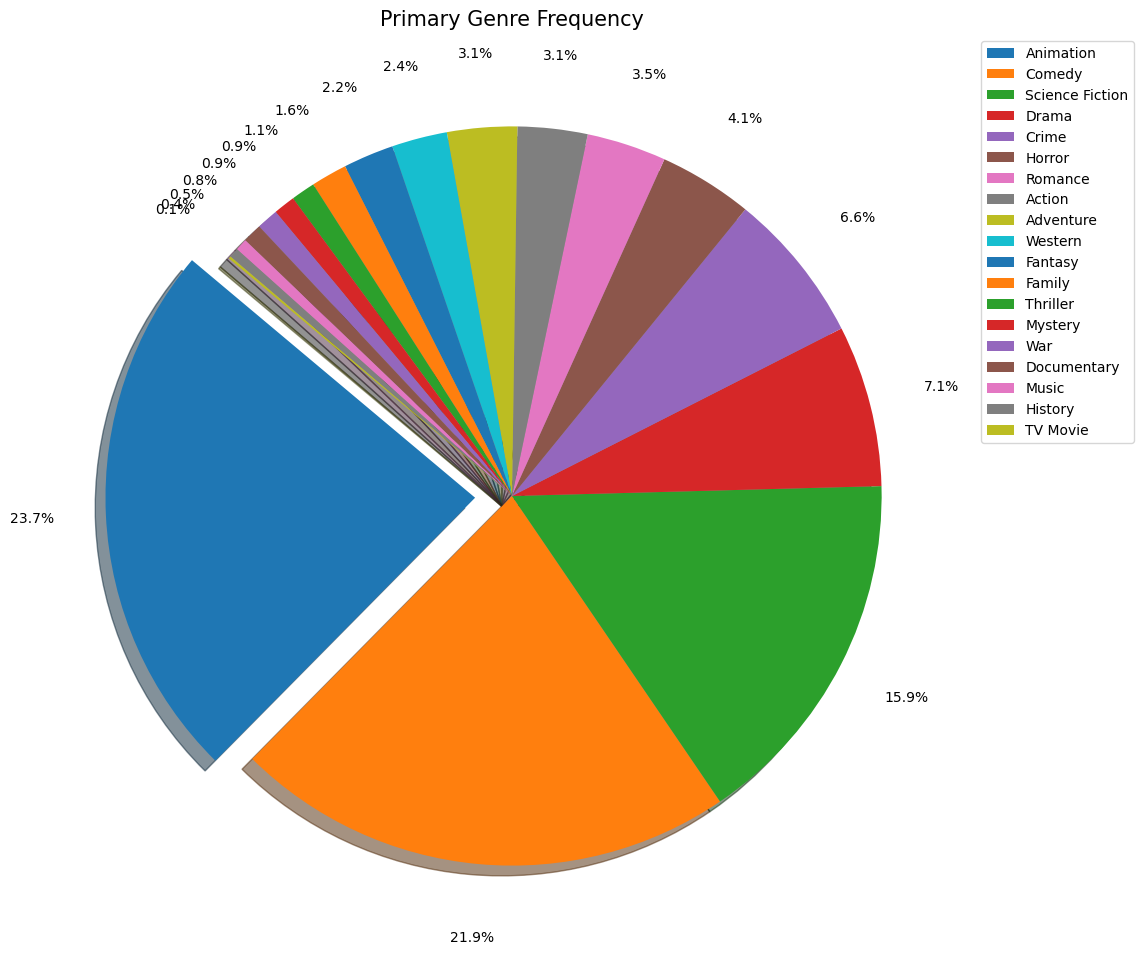

In [334]:
# Create visualization
plt.figure(figsize=(12, 12))
categories = genre_df['primary_genre'].unique()
plt.pie(primary_genre, autopct= "%1.1f%%", shadow=True, startangle=140, pctdistance=1.2, explode=explode)
plt.legend(categories, loc='best', bbox_to_anchor=(1, 1))
plt.title('Primary Genre Frequency', fontsize=15)

# Export an image of this figure to the 'Output' folder 
plt.savefig("Output/06 Primary Genre Frequency.png", bbox_inches='tight')
plt.show()

### Analysis of Number of Movies Produced based on their Primary Genre
Data seems to vary largely every time a sample is pulled. 
The above pie chart displays the top three movies genres.

## Exploring the Distribution of Budget Data

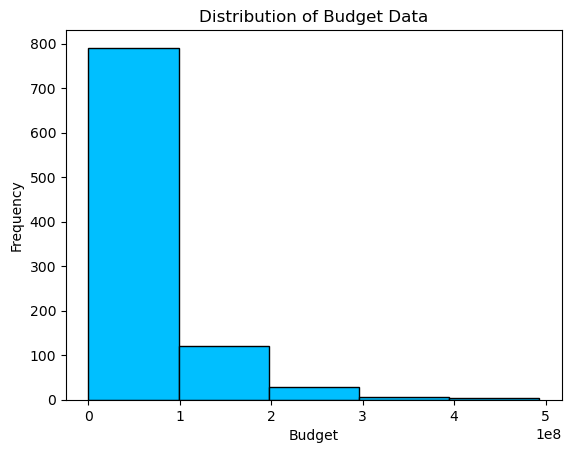

In [335]:
# Create Visualization
# Plot a histogram of budget
plt.hist(movie_list['infl_adj_budget'],bins=5, color='deepskyblue', edgecolor='k')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.title('Distribution of Budget Data')

# Export an image of this figure to the 'Output' folder 
plt.savefig("Output/07 Histogram of Budget.png",bbox_inches='tight')

In [336]:
# Null Hypothesis(H0): Budget data is normally distributed
from scipy.stats import shapiro
DataToTest = movie_list['infl_adj_budget']
stat,p = shapiro(DataToTest)
print(f"stat: {stat},p: {p}")
if(p>0.05):
    print("Accept NULL Hypothesis.") 
else:
    print("Reject NULL Hypothesis.") 

stat: 0.7533113956451416,p: 2.3068050660203752e-35
Reject NULL Hypothesis.


### Analyzing the Distribution of Budget Data 
The budget data is not normally distributed.

# Scatter Plots with Linear Regression

In [337]:
# Create a function for computing linear regression
def lin_regress(xval, yval, x_label, y_label,title): 
    x_values = xval
    y_values = yval
    
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values, c='blueviolet',s=6 )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot(x_values,regress_values,"r-")
    # plt.annotate(line_eq,(10,20),fontsize=15,color="red")
    plt.legend(['Regression Line: y = {:.2f}x + {:.2f}'.format(slope, intercept)])
    print("The r-value is: ",rvalue)
    print(f"Slope: {slope}, Intercept: {intercept}")

## Runtime of Movies over the Past Century

The r-value is:  -0.08490625734327555
Slope: -0.1179923857950272, Intercept: 346.01127995846736


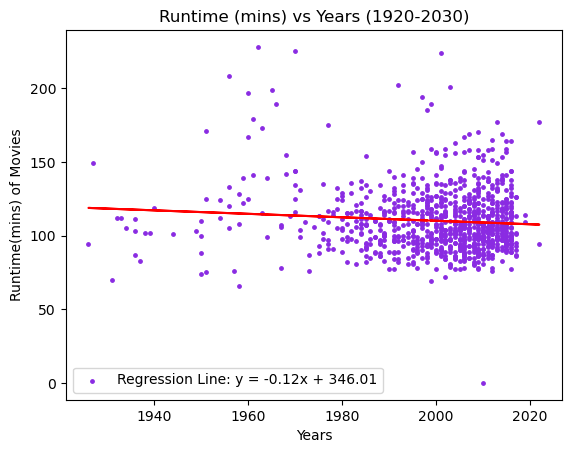

In [338]:
# Create Visualization
# Create a scatter plot for regression analysis
xval = movie_list['Year']
yval = movie_list['runtime'].astype(int)
x_label='Years'
y_label='Runtime(mins) of Movies'
runtime_title="Runtime (mins) vs Years (1920-2030)"

lin_regress(xval, yval, x_label, y_label,runtime_title)
# Export an image of this figure to the 'Output' folder 
plt.savefig("Output/08 Runtime vs Years.png")

### Analyzing Runtime of Movies over the Past Century

There is a very weak negative relationship between the runtime and year of the movies.

The runtime of the movies has slightly reduced over the past century. 


## Budget vs TMDB Rating

The r-value is:  0.07936603061211239
Slope: 1.0947540550885554e-09, Intercept: 6.392658855401254


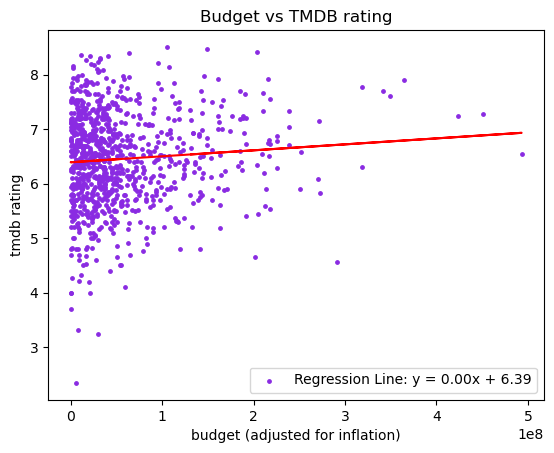

In [339]:
# Create a scatter plot for regression analysis: Budget vs. tmdb

xval = movie_list['infl_adj_budget'].astype(int)
yval = movie_list['tmdb_rating'].astype(float)
x_label='budget (adjusted for inflation)'
y_label='tmdb rating'
budget_title="Budget vs TMDB rating"

lin_regress(xval, yval, x_label, y_label,budget_title)
# Export an image of this figure to the 'Output' folder 
plt.savefig("Output/09 Budget vs TMDB rating.png",bbox_inches='tight')

### Analyzing the correlation between budget and TMDB rating of movies
Based on above statistics, there is no correlation between the budget of movies and their TMDb ratings in this sample dataset.
This suggests that factors other than budget have a more substantial impact on a movie's TMDb rating.

##  Budget vs IMDB Rating

The r-value is:  0.04042314374403547
Slope: 6.822097605477022e-10, Intercept: 6.459920702638858


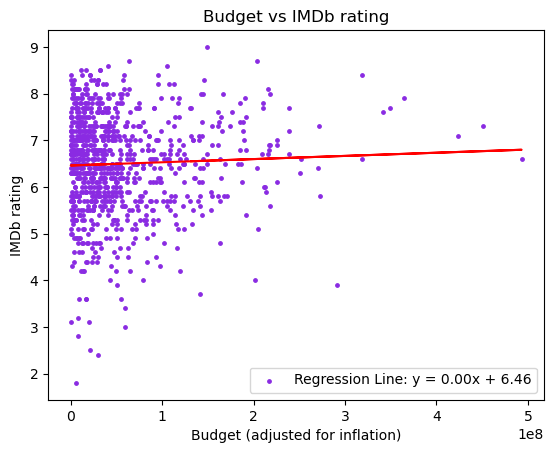

In [340]:
# Create Visualization
# Create a scatter plot for regression analysis: Budget vs. imbd Rating

xval = movie_list['infl_adj_budget'].astype(int)
yval = movie_list['imdb_rating'].astype(float)
x_label='Budget (adjusted for inflation)'
y_label='IMDb rating'
rating_title="Budget vs IMDb rating"

lin_regress(xval, yval, x_label, y_label,rating_title)
# Export an image of this figure to the 'Output' folder 
plt.savefig("Output/10 Budget vs IMDb Rating.png",bbox_inches='tight')

### Analyzing the correlation between budget and IMDb rating of movies
There is a weak relationship between the budget and IMDb rating of movies.
The overall trend in this sample dataset suggests that budget alone is not a strong predictor of IMDb ratings.

## Revenue vs IMDb Rating

The r-value is:  0.2398193319397748
Slope: 7.336739064927035e-10, Intercept: 6.363675326479135


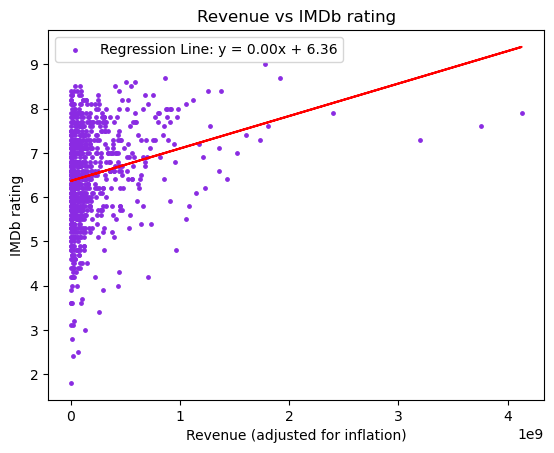

In [341]:
# Create Visualization
# Create a scatter plot for regression analysis: Revenue vs. imbd Rating

xval = movie_list['infl_adj_revenue'].astype(float)
yval = movie_list['imdb_rating'].astype(float)
x_label='Revenue (adjusted for inflation)'
y_label='IMDb rating'
revenue_title="Revenue vs IMDb rating"

lin_regress(xval, yval, x_label, y_label,revenue_title)
# Export an image of this figure to the 'Output' folder 
plt.savefig("Output/11 Revenue vs IMDb Rating.png", bbox_inches='tight')

### Analyzing the correlation between Revenue vs IMDb Rating
The positive correlation suggests that, on average, movies with higher revenue tend to have slightly higher IMDb ratings.

## Revenue vs. Runtime

The r-value is:  0.19835717568273914
Slope: 1.2822564374551385e-08, Intercept: 107.71007894544111


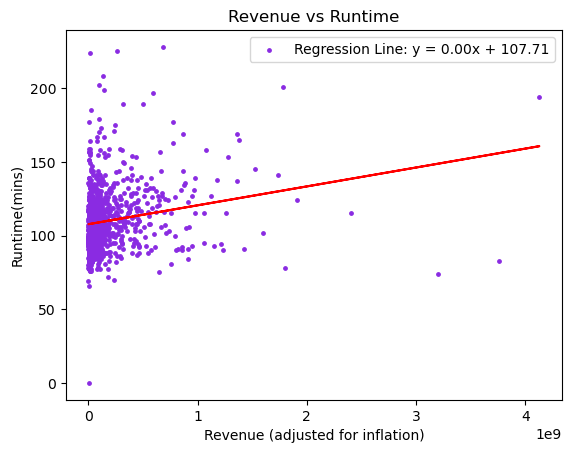

In [342]:
# Create a scatter plot for regression analysis: Revenue vs. Runtime

xval = movie_list['infl_adj_revenue'].astype(float)
yval = movie_list['runtime'].astype(int)
x_label='Revenue (adjusted for inflation)'
y_label='Runtime(mins)'
revenue_title="Revenue vs Runtime"
lin_regress(xval, yval, x_label, y_label,revenue_title)

# Export an image of this figure to the 'Output' folder 
plt.savefig("Output/12 Revenue vs Runtime.png",bbox_inches='tight')

### Analyzing the correlation between Revenue vs Runtime
There is a weak positive corelation between runtime and revenue of movies. 
This suggests that,on average, longer movies tend to generate slightly higher revenue. 

# Data Testing

In [180]:
#TEST NULL HYPOTHESIS
#H0: There is a significant association between budget and revenue of a movie.
#H1: There is no significant association between budget and revenue of a movie
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(movie_list['infl_adj_budget'], movie_list['infl_adj_revenue'])

# Perform the chi-square test for independence
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)

alpha = 0.05  # Significance level

if p < alpha:
    print("Accept Null Hypothesis")
else:
    print("Reject Null Hypothesis")

Chi-Square Statistic: 768158.9999999995
P-value: 0.0006091965235673813
Accept Null Hypothesis


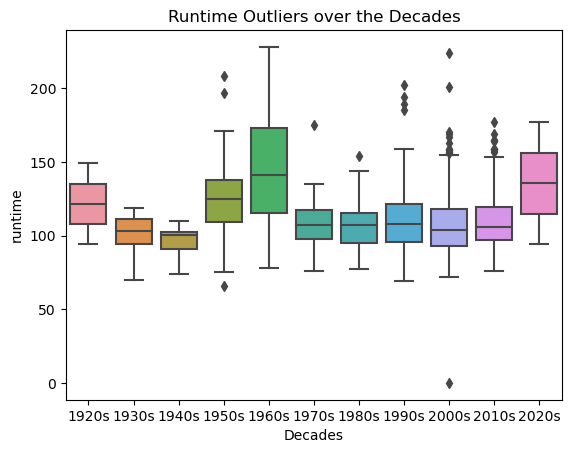

In [344]:
# Identifying Outliers in Movie Runtimes Over the Years
import seaborn as sns
ax = sns.boxplot(x='Decades',y='runtime',data=movie_list)
plt.title("Runtime Outliers over the Decades")

# Export an image of this figure to the 'Output' folder 
plt.savefig("Output/13 Runtime Outliers over the Decades.png", bbox_inches='tight')

# Incorporating Oscar and Golden Globe Data

### Oscar dataset import and cleaning

In [178]:
# Import the Oscar csv to analyze
oscar_list = pd.read_csv("Resources/the_oscar_award.csv")
print(oscar_list.shape)
oscar_list.head(2)

(10765, 7)


,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True


In [346]:
# Check for NaN values in the film column of the Oscar List
oscar_list["film"].isnull().value_counts()

film
False    10450
True       315
Name: count, dtype: int64

In [347]:
# Drop the NaN values and the "False" winners to clean the data
oscar_list.dropna(how="any", inplace=True)
oscar_winners = oscar_list["winner"]==True

oscars = oscar_list[oscar_winners]
print(oscars.shape)
oscars

(2149, 7)


,year_film,year_ceremony,ceremony,category,name,film,winner
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
6,1927,1928,1,ART DIRECTION,William Cameron Menzies,The Dove;,True
9,1927,1928,1,CINEMATOGRAPHY,Charles Rosher,Sunrise,True
10,1927,1928,1,CINEMATOGRAPHY,Karl Struss,Sunrise,True
...,...,...,...,...,...,...,...
10743,2022,2023,95,SOUND,"Mark Weingarten, James H. Mather, Al Nelson, C...",Top Gun: Maverick,True
10745,2022,2023,95,VISUAL EFFECTS,"Joe Letteri, Richard Baneham, Eric Saindon and...",Avatar: The Way of Water,True
10753,2022,2023,95,WRITING (Adapted Screenplay),Screenplay by Sarah Polley,Women Talking,True
10755,2022,2023,95,WRITING (Original Screenplay),Written by Daniel Kwan & Daniel Scheinert,Everything Everywhere All at Once,True


In [348]:
# Count the number of wins each film has and turn that series into a DataFrame
oscar_wins = oscars[["film", "year_film"]].value_counts()
oscar_win_df = oscar_wins.reset_index()
oscar_win_df

,film,year_film,count
0,Titanic,1997,11
1,Ben-Hur,1959,11
2,The Lord of the Rings: The Return of the King,2003,11
3,West Side Story,1961,10
4,The Last Emperor,1987,9
...,...,...,...
1325,Knighty Knight Bugs,1958,1
1326,Kokoda Front Line!,1942,1
1327,Kolya,1996,1
1328,Kon-Tiki,1951,1


In [349]:
# Rename the columns of the DataFrame to cleanly merge with the movie data
oscar_win_df = oscar_win_df.rename(columns={'film': 'Title', 'year_film': 'Year', 'count': 'Oscar_Wins'})
oscar_win_df

,Title,Year,Oscar_Wins
0,Titanic,1997,11
1,Ben-Hur,1959,11
2,The Lord of the Rings: The Return of the King,2003,11
3,West Side Story,1961,10
4,The Last Emperor,1987,9
...,...,...,...
1325,Knighty Knight Bugs,1958,1
1326,Kokoda Front Line!,1942,1
1327,Kolya,1996,1
1328,Kon-Tiki,1951,1


### Golden Globe dataset import and cleaning

In [179]:
# Import the golden globes csv to analyze
gglobe_list = pd.read_csv("Resources/golden_globe_awards.csv")
print(gglobe_list.shape)
gglobe_list.head()

# gglobe_list

(7991, 7)


,year_film,year_award,ceremony,category,nominee,film,win
0,1943,1944,1,Best Performance by an Actress in a Supporting...,Katina Paxinou,For Whom The Bell Tolls,True
1,1943,1944,1,Best Performance by an Actor in a Supporting R...,Akim Tamiroff,For Whom The Bell Tolls,True
2,1943,1944,1,Best Director - Motion Picture,Henry King,The Song Of Bernadette,True
3,1943,1944,1,Picture,The Song Of Bernadette,NaN,True
4,1943,1944,1,Actress In A Leading Role,Jennifer Jones,The Song Of Bernadette,True


In [351]:
# Check for NaN values in the film column of the Golden Globe List
gglobe_list["film"].isnull().value_counts()

film
False    6191
True     1800
Name: count, dtype: int64

In [352]:
# Drop the NaN values and the "False" winners to clean the data
# gglobe_list.dropna(how="any", inplace=True)
gglobe_winners = gglobe_list["win"]==True
# gglobe_winners
gglobes = gglobe_list[gglobe_winners]

# Update the 'film' column where it is NaN with values from the 'nominee' column
gglobes['film'] = gglobes['film'].fillna(gglobes['nominee'])
gglobes.sample(10)

# print(gglobes.shape)
# gglobes

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_5196/1505913114.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gglobes['film'] = gglobes['film'].fillna(gglobes['nominee'])


,year_film,year_award,ceremony,category,nominee,film,win
4498,1992,1993,50,Best Director - Motion Picture,Clint Eastwood,Unforgiven,True
3749,1986,1987,44,Best Motion Picture - Foreign Language,"Assault, The","Netherlands, Fons Rademakers",True
7417,2015,2016,73,Best Original Score - Motion Picture,Ennio Morricone,The Hateful Eight,True
1967,1972,1973,30,Best Performance by an Actor In A Television S...,Peter Falk,Columbo,True
3548,1984,1985,42,Best Performance by an Actress in a Television...,Shelley Long,Cheers,True
5174,1997,1998,55,Best Performance by an Actress In A Television...,Christine Lahti,Chicago Hope,True
3122,1981,1982,39,Best Television Limited Series or Motion Pictu...,Bill,Bill,True
3102,1981,1982,39,Best Motion Picture - Foreign Language,Chariots of Fire,"United Kingdom, Hugh Hudson",True
5117,1997,1998,55,Best Performance by an Actor in a Supporting R...,Burt Reynolds,Boogie Nights,True
1202,1965,1966,23,Henrietta Award (World Film Favorites),Natalie Wood,Natalie Wood,True


In [353]:
# Count the number of wins each film has and turn that series into a DataFrame
gglobe_count = gglobes[["film", "year_film"]].value_counts()
gglobe_win_df = gglobe_count.reset_index()
gglobe_win_df

,film,year_film,count
0,La La Land,2016,7
1,Lawrence Of Arabia,1962,6
2,One Flew Over The Cuckoo's Nest,1975,6
3,Midnight Express,1978,6
4,Ordinary People,1980,5
...,...,...,...
1324,House,2006,1
1325,House of Cards,2013,1
1326,House of Cards,2014,1
1327,House of Lies,2012,1


In [354]:
# Rename the columns of the DataFrame to cleanly merge with the movie data
gglobe_win_df = gglobe_win_df.rename(columns={'film': 'Title', 'year_film': 'Year', 'count': 'Golden_Globe_Wins'})
gglobe_win_df

,Title,Year,Golden_Globe_Wins
0,La La Land,2016,7
1,Lawrence Of Arabia,1962,6
2,One Flew Over The Cuckoo's Nest,1975,6
3,Midnight Express,1978,6
4,Ordinary People,1980,5
...,...,...,...
1324,House,2006,1
1325,House of Cards,2013,1
1326,House of Cards,2014,1
1327,House of Lies,2012,1


## Merging the Oscars and Golden Globes DataFrames into the Movie List DataFrame

In [355]:
# Referencing the movie_list for ease of coding
print(movie_list.shape)
movie_list.head(1)

(949, 18)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category
0,Pokémon: The First Movie,1998,10228,tt0190641,"Animation, Family, Adventure, Fantasy, Action",85,30000000,163644662.0,Japan,25.593,6.911,6.2,"44,979",53862883.435583,293812445.138712,2.399496e+08,1990s,Low Budget


In [356]:
# Individually merge the Oscars and Golden Globes DataFrames into the master movie list
oscar_awards = pd.merge(movie_list, oscar_win_df, how="inner", on=["Title", "Year"])
print(oscar_awards.shape)
oscar_awards.head()

(66, 19)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Oscar_Wins
0,Happy Feet,2006,9836,tt0366548,"Animation, Comedy, Family",108,100000000,384335608.0,Australia,41.868,6.200,6.4,"195,145",145166170.634921,557925284.52004,4.127591e+08,2000s,Low Budget,1
1,The Alamo,1960,11209,tt0053580,Western,167,12000000,7900000.0,United States of America,14.431,7.178,6.8,"16,993",118643918.918919,78107246.621622,-4.053667e+07,1950s,Low Budget,1
2,Swing Time,1936,20325,tt0028333,"Comedy, Music, Romance",103,886000,2600000.0,United States of America,7.631,6.800,7.5,"14,333",18654124.460432,54741223.021583,3.608710e+07,1930s,Low Budget,1
3,Interstellar,2014,157336,tt0816692,"Adventure, Drama, Science Fiction",169,165000000,701729206.0,"United Kingdom, United States of America",165.291,8.419,8.7,"1,995,560",203974363.848337,867483444.77363,6.635091e+08,2010s,Average Budget,1
4,Black Swan,2010,44214,tt0947798,"Drama, Thriller, Horror",108,13000000,329398046.0,United States of America,36.068,7.674,8.0,"800,980",17447421.763217,442088202.810883,4.246408e+08,2000s,Low Budget,1


In [357]:
gglobe_awards = pd.merge(movie_list, gglobe_win_df, how="inner", on=["Title", "Year"])
print(gglobe_awards.shape)
gglobe_awards.head()

(45, 19)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Golden_Globe_Wins
0,Happy Feet,2006,9836,tt0366548,"Animation, Comedy, Family",108,100000000,384335608.0,Australia,41.868,6.200,6.4,"195,145",145166170.634921,557925284.52004,4.127591e+08,2000s,Low Budget,1
1,Runaway Train,1985,11893,tt0089941,"Action, Thriller, Drama, Adventure",111,9000000,7936012.0,United States of America,13.841,6.981,7.2,"31,759",24478578.066914,21584698.809108,-2.893879e+06,1980s,Low Budget,1
2,The Alamo,1960,11209,tt0053580,Western,167,12000000,7900000.0,United States of America,14.431,7.178,6.8,"16,993",118643918.918919,78107246.621622,-4.053667e+07,1950s,Low Budget,1
3,A Walk in the Clouds,1995,9560,tt0114887,"Drama, Romance",103,20000000,50012507.0,United States of America,23.71,7.249,6.7,"35,767",38406167.979003,96039437.244652,5.763327e+07,1990s,Low Budget,1
4,Black Swan,2010,44214,tt0947798,"Drama, Thriller, Horror",108,13000000,329398046.0,United States of America,36.068,7.674,8.0,"800,980",17447421.763217,442088202.810883,4.246408e+08,2000s,Low Budget,1


In [358]:
# Make a DataFrame merging Golden Globe Awards data onto the merged Oscar data to show only films with wins in both
both_awards = pd.merge(oscar_awards, gglobe_win_df, how="inner", on=["Title", "Year"])
print(both_awards.shape)
both_awards

(30, 20)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Oscar_Wins,Golden_Globe_Wins
0,Happy Feet,2006,9836,tt0366548,"Animation, Comedy, Family",108,100000000,384335608.0,Australia,41.868,6.200,6.4,"195,145",145166170.634921,557925284.52004,4.127591e+08,2000s,Low Budget,1,1
1,The Alamo,1960,11209,tt0053580,Western,167,12000000,7900000.0,United States of America,14.431,7.178,6.8,"16,993",118643918.918919,78107246.621622,-4.053667e+07,1950s,Low Budget,1,1
2,Black Swan,2010,44214,tt0947798,"Drama, Thriller, Horror",108,13000000,329398046.0,United States of America,36.068,7.674,8.0,"800,980",17447421.763217,442088202.810883,4.246408e+08,2000s,Low Budget,1,1
3,Raging Bull,1980,1578,tt0081398,Drama,129,18000000,23000000.0,United States of America,25.734,7.953,8.1,"369,497",63929490.291262,81687682.038835,1.775819e+07,1970s,Low Budget,2,1
4,Midnight Cowboy,1969,3116,tt0064665,Drama,113,3600000,44785053.0,United States of America,10.247,7.515,7.8,"117,027",28707302.452316,357127239.392779,3.284199e+08,1960s,Low Budget,3,1
5,The Social Network,2010,37799,tt1285016,Drama,121,40000000,224920315.0,United States of America,29.569,7.360,7.8,"737,649",53684374.656052,301867661.455429,2.481833e+08,2000s,Low Budget,3,4
6,Julia,1977,42222,tt0076245,Drama,117,7840000,20700000.0,United States of America,7.319,6.560,7.1,"10,226",37861636.963696,99966311.881188,6.210467e+07,1970s,Low Budget,3,2
7,Sense and Sensibility,1995,4584,tt0114388,"Drama, Romance",136,16000000,134582776.0,United Kingdom,25.949,7.440,7.7,"122,126",30724934.383202,258440435.106824,2.277155e+08,1990s,Low Budget,1,2
8,Mary Poppins,1964,433,tt0058331,"Comedy, Family, Fantasy",139,6000000,103082380.0,United States of America,33.177,7.571,7.8,"181,073",56642903.225806,973147545.770968,9.165046e+08,1960s,Low Budget,5,1
9,As Good as It Gets,1997,2898,tt0119822,"Drama, Comedy, Romance",139,50000000,314178011.0,United States of America,20.922,7.394,7.7,"312,036",91169781.931464,572870815.010623,4.817010e+08,1990s,Low Budget,2,3


In [359]:
# Sum the Oscar and Golden Globe Award wins into a new column called cumulative awards
both_awards['Cumulative_Awards'] = ''
for index,row in both_awards.iterrows():
    both_awards.loc[index, "Cumulative_Awards"] = both_awards.loc[index,'Oscar_Wins']+both_awards.loc[index,'Golden_Globe_Wins']

both_awards.sort_values(by='Cumulative_Awards',ascending = False,inplace=True)
both_awards.head()

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,...,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Oscar_Wins,Golden_Globe_Wins,Cumulative_Awards
21,Titanic,1997,597,tt0120338,"Drama, Romance",194,200000000,2264162353.0,United States of America,133.844,...,7.9,"1,248,724",364679127.725857,4128463759.608816,3.763785e+09,1990s,High Budget,11,4,15
20,The Lord of the Rings: The Return of the King,2003,122,tt0167260,"Adventure, Fantasy, Action",201,94000000,1118888979.0,"New Zealand, United States of America",98.322,...,9.0,"1,920,154",149508532.608696,1779611163.854592,1.630103e+09,2000s,Low Budget,11,4,15
26,Kramer vs. Kramer,1979,12102,tt0079417,Drama,105,8000000,106260000.0,United States of America,16.906,...,7.8,"151,535",32248484.848485,428340500.0,3.960920e+08,1970s,Low Budget,5,4,9
13,A Beautiful Mind,2001,453,tt0268978,"Drama, Romance",135,58000000,316800000.0,United States of America,38.786,...,8.2,"963,266",95844099.378882,523507080.745342,4.276630e+08,2000s,Low Budget,4,4,8
24,Gravity,2013,49047,tt1454468,"Science Fiction, Thriller, Drama",91,105000000,723192705.0,"United Kingdom, United States of America",27.054,...,7.7,"848,981",131907497.950265,908519430.975566,7.766119e+08,2010s,Low Budget,7,1,8


In [360]:
# Sort the data descending and grab the top 20 cumulative winners to do visualizations with
top20_both_awards = both_awards.sort_values(by='Cumulative_Awards', ascending=False)
top20_movies = top20_both_awards.iloc[0:20, :] 
top20_movies.head()

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,...,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Oscar_Wins,Golden_Globe_Wins,Cumulative_Awards
21,Titanic,1997,597,tt0120338,"Drama, Romance",194,200000000,2264162353.0,United States of America,133.844,...,7.9,"1,248,724",364679127.725857,4128463759.608816,3.763785e+09,1990s,High Budget,11,4,15
20,The Lord of the Rings: The Return of the King,2003,122,tt0167260,"Adventure, Fantasy, Action",201,94000000,1118888979.0,"New Zealand, United States of America",98.322,...,9.0,"1,920,154",149508532.608696,1779611163.854592,1.630103e+09,2000s,Low Budget,11,4,15
26,Kramer vs. Kramer,1979,12102,tt0079417,Drama,105,8000000,106260000.0,United States of America,16.906,...,7.8,"151,535",32248484.848485,428340500.0,3.960920e+08,1970s,Low Budget,5,4,9
13,A Beautiful Mind,2001,453,tt0268978,"Drama, Romance",135,58000000,316800000.0,United States of America,38.786,...,8.2,"963,266",95844099.378882,523507080.745342,4.276630e+08,2000s,Low Budget,4,4,8
24,Gravity,2013,49047,tt1454468,"Science Fiction, Thriller, Drama",91,105000000,723192705.0,"United Kingdom, United States of America",27.054,...,7.7,"848,981",131907497.950265,908519430.975566,7.766119e+08,2010s,Low Budget,7,1,8


## Top 20 movies with total Oscar & Golden Globe wins

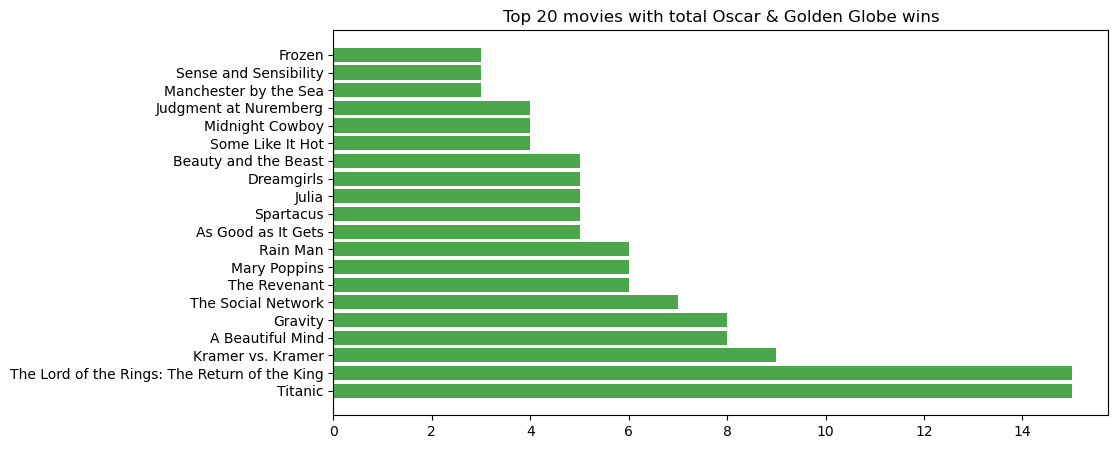

In [361]:
# Create a bar chart visualization of the top 20 movies with cumulative award wins
x=top20_movies['Title']
y=top20_movies['Cumulative_Awards']
plt.figure(figsize=(10,5))
plt.title('Top 20 movies with total Oscar & Golden Globe wins')
plt.barh(x,y,color='green',alpha=0.7)

# Export an image of this figure to the 'Output' folder 
plt.savefig("Output/14 Top 20 winners of both awards.png", bbox_inches='tight')

In [362]:
# Take a look at how many awards were won by each decade
per_decade_wins=both_awards['Decades'].value_counts()
per_decade_wins

Decades
2000s    8
2010s    6
1990s    5
1960s    4
1950s    3
1970s    3
1980s    1
1920s    0
1930s    0
1940s    0
2020s    0
Name: count, dtype: int64

## Movies with Oscar and Golden Globe awards by Decade 

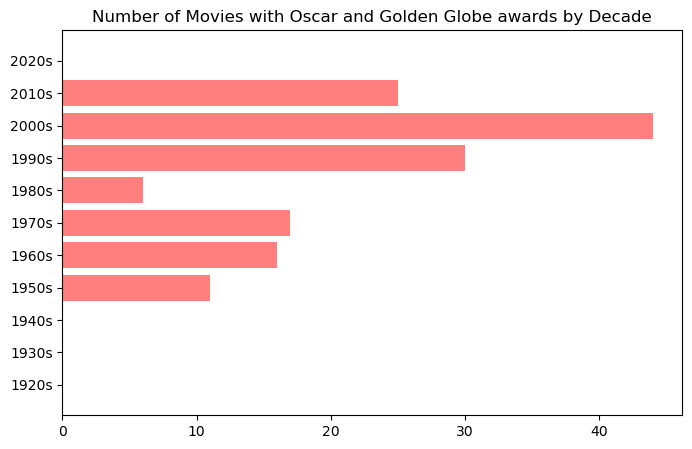

In [363]:
# Create Visualization
# Bar plot for cumulative Oscar and Golden Globe wins by Decade
decade_groupby = both_awards.groupby('Decades')
decades_sum=decade_groupby['Cumulative_Awards'].sum().reset_index()
decades_sum['Cumulative_Awards']
x=decades_sum['Decades']
y=decades_sum['Cumulative_Awards']
#plt.xlabel("Total oscar and golden globe wins")

plt.figure(figsize=(8,5))
plt.title(f"Number of Movies with Oscar and Golden Globe awards by Decade")
plt.barh(x,y,color='red',alpha=0.5)

# Export an image of this figure to the 'Output' folder 
plt.savefig("Output/15 Winners of both awards by decade.png", bbox_inches='tight')